In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import os
import sys
from typing import (
    Dict, 
    List, 
    Tuple,
    Set,
    Any
)
import warnings

from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
from joblib import load, dump

from optbinning import OptimalBinning

import seaborn as sns
import matplotlib.pyplot as plt

(CVXPY) Jun 20 07:22:26 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 20 07:22:26 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.metrics import Metrics

In [4]:
# set constants
COLUMNS_DICT: Dict[str, str] = {
'OPTIN_11SCN_ML': 'Num', 
'G5_ND_SPECII': 'Num', 
'SP_F2_33': 'Num', 
'AFF_B_09_01': 'Num', 
'TRD_A_20': 'Num', 
'TRD_A_08': 'Num', 
'VM01_SP_VM2_15': 'Num', 
# 'GEN11_SP_N_92': 'Char', 
'SP_G_37': 'Num', 
'E4_Q_17': 'Char', 
'TRD_C_07': 'Num', 
'TRD_B_20': 'Num', 
'SP_B2_18': 'Num', 
'SPA_F2_33': 'Num', 
'VM01_SP_VM2_14': 'Num', 
'SP_G_38': 'Num', 
'TRD_O_05': 'Num', 
'E1_A_09': 'Num', 
'TRD_O_07': 'Num', 
'ND_INC_03': 'Num', 
'VM01_SP_VM2_17': 'Num', 
'SP_B1_14': 'Num', 
'GEN11_SP_N_91': 'Num', 
'GEN11_SP_EDI_07': 'Num', 
'ND_ECC_06': 'Num', 
'TRD_B_18': 'Num', 
'TRD_B_08': 'Num', 
'EA5_S_01': 'Num', 
'CLU_CLI_L6M_NPR_L6M': 'Num', 
'E1_B_06': 'Num', 
# 'GEN11_SP_K_80': 'Char', 
'SP_I_63_01': 'Num', 
'SP_B2_20': 'Num', 
'E4_Q_04': 'Num', 
'ND_ECC_04': 'Num', 
'VM08_SP_VM2_15': 'Num', 
'VAL_DELINQ_ACCS': 'Num', 
'VM08_SP_VM2_20': 'Num', 
'EA1_D_02': 'Num', 
'AFF_E_07_01': 'Num', 
'TRD_O_06': 'Num', 
# 'E2_G_08': 'Num',  IV < 0.1
'AFF_T_07_01': 'Num', 
'VM02_SP_VM1_18': 'Num', 
'VM01_SP_VM2_24': 'Num'

} 

COLS_MAN_CORRECT: Dict[str, Dict[str, Any]] = dict()

MIN_IV: float = 0.1
CORR_PEARSON_CUT_OFF: float = 0.75
RANDOM_SEED: int = 42


TARGET_NAME: str = 'GB6_Flag_2Limit'
PALETTE_TARGET: Dict[str, str] = {
    'G': 'green',
    'B': 'red',
    'I': 'black'
}
TARGET_BIN: str = f'_{TARGET_NAME}_bin'
TARGET_BIN_IisB: str = f'_{TARGET_NAME}_bin_IisB'

PROJECT_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH: str = os.path.join(PROJECT_PATH, 'data')
OPT_BIN_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'optbinners_2.0')

In [5]:
COLS_TO_SAVE: List[str] = [
'OPTIN_11SCN_ML',
'G5_ND_SPECII',
'SP_F2_33',
'AFF_B_09_01',
'TRD_A_20',
'TRD_A_08',
'VM01_SP_VM2_15',
# 'GEN11_SP_N_92',
'SP_G_37',
'E4_Q_17',
'TRD_C_07',
'TRD_B_20',
'SP_B2_18',
'SPA_F2_33',
'VM01_SP_VM2_14',
'VM01_SP_VM2_24',
'SP_G_38',
'TRD_O_05',
'E1_A_09',
'TRD_O_07',
'ND_INC_03',
'VM01_SP_VM2_17',
'SP_B1_14',
'GEN11_SP_N_91',
'GEN11_SP_EDI_07',
'ND_ECC_06',
'TRD_B_18',
'TRD_B_08',
'EA5_S_01',
'CLU_CLI_L6M_NPR_L6M',
'E1_B_06',
# 'GEN11_SP_K_80',
'SP_I_63_01',
'SP_B2_20',
'E4_Q_04',
'ND_ECC_04',
'VM08_SP_VM2_15',
'VAL_DELINQ_ACCS',
# 'ND_ERL_01', # IV < 0.1
'VM08_SP_VM2_20',
'EA1_D_02',
'AFF_E_07_01',
'TRD_O_06',
# 'E2_G_08', # IV < 0.1
'AFF_T_07_01',
'VM02_SP_VM1_18',
'GEN11_SP_K_80_PR',
'GEN11_SP_K_80_TO',
'GEN11_SP_K_80_JSOther',
'GEN11_SP_N_92_ABOther', 
]

In [6]:
TRAIN_BIN_FROM: datetime.date = pd.to_datetime('2021-07-01').date()
TRAIN_BIN_TO: datetime.date = pd.to_datetime('2021-12-01').date()

In [7]:
TRAIN_FROM: datetime.date = pd.to_datetime('2021-12-01').date()
TRAIN_TO: datetime.date = pd.to_datetime('2022-01-01').date()

VAL_FROM: datetime.date = pd.to_datetime('2023-01-01').date()
VAL_TO: datetime.date = pd.to_datetime('2023-05-01').date()

TEST_FROM: datetime.date = pd.to_datetime('2023-05-01').date()
TEST_TO: datetime.date = pd.to_datetime('2023-08-01').date()

In [8]:
# read data
df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2.csv'))

C:\Users\hdychko\AppData\Local\Temp\ipykernel_648\1622656214.py:2: DtypeWarning: Columns (310,1307,1349,1351,1352,1400,1401,1402,1403,1404,1405) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2.csv'))


In [9]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 1774


In [10]:
#  check if all necessary columns are present
assert df[COLUMNS_DICT.keys()].shape[1] == len(COLUMNS_DICT)

# Functions

In [11]:
def count_target_per_bin(data: pd.DataFrame, target_name: str, columns: List[str]) -> pd.DataFrame:
    df_bin_sts = pd.DataFrame()
    for col_name in [f'Bin{col[:-len('OptBin')]}' for col in columns]:
        temp = data.groupby(target_name)[col_name].value_counts().reset_index(name='n').pivot(index=col_name, columns=target_name, values='n')
        temp = temp.reset_index()
        temp = temp.rename(columns={col_name: 'Bin'})
        temp['Feature'] = col_name[len('Bin'):]
        df_bin_sts = pd.concat((df_bin_sts, temp))
    df_bin_sts = df_bin_sts.fillna(0)
    return df_bin_sts

In [12]:
def count_obs_per_bin(data: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    df_bin_sts = pd.DataFrame()
    for col_name in [f'Bin{col[:-len('OptBin')]}' for col in columns]:
        temp = data[col_name].value_counts().reset_index(name='n')
        temp = temp.rename(columns={col_name: 'Bin'})
        temp['Feature'] = col_name[len('Bin'):]
        df_bin_sts = pd.concat((df_bin_sts, temp))
    return df_bin_sts

In [102]:
def recompute_woe(data: pd.DataFrame, cols: List[str], target_name: str):
    df_bin_sts = count_obs_per_bin(data=data, columns=cols)
    df_bin_sts_t = count_target_per_bin(data=data, target_name=target_name, columns=cols)
    df_bin_sts = pd.merge(df_bin_sts_t, df_bin_sts, on=['Feature', 'Bin'])
    
    assert not df_bin_sts[['Bin', 'Feature', 'n']].duplicated().any()
    assert not df_bin_sts[['Bin', 'Feature', 'B', 'G']].duplicated().any()
    del df_bin_sts_t
    
    
    df_bin_sts['Event rate'] = df_bin_sts['B'] / df_bin_sts['n']
    df_bin_sts['WoE'] = np.log((df_bin_sts.G / df_bin_sts.G.sum()) / (df_bin_sts.B/df_bin_sts.B.sum()))
    df_bin_sts.loc[df_bin_sts.WoE.isin([np.inf]), 'WoE'] = 0
    df_bin_sts = df_bin_sts.fillna(0)

    df_bin_sts['Count (%)'] = df_bin_sts['n'] / df_bin_sts['n'].sum()
    
    return df_bin_sts

# Preprocessing

## Create the target 'I', 'B' are 1, 'G' - 0

In [14]:
warnings.filterwarnings("ignore", category=FutureWarning)
df[TARGET_BIN_IisB] = df[TARGET_NAME].replace(
    {
        'G': 0,
        'B': 1, 
        'I': 1
    }
)

In [15]:
# check the distribution
df.groupby(TARGET_NAME)[TARGET_BIN_IisB].value_counts()

GB6_Flag_2Limit  _GB6_Flag_2Limit_bin_IisB
B                1                             4449
G                0                            99444
I                1                             6569
Name: count, dtype: int64

In [16]:
# compare with already existed column
df.groupby(TARGET_NAME)[TARGET_BIN].value_counts()

GB6_Flag_2Limit  _GB6_Flag_2Limit_bin
B                1                        4449
G                0                       99444
I                0                        6569
Name: count, dtype: int64

## Convert dates to the corresponding types

In [17]:
for col in ['_RDATE_EOM', '_RDATE']:
    df[col] = pd.to_datetime(df[col]).dt.date

In [18]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

## Dafine dataset to train OptBin on

In [19]:
df_train: pd.DataFrame = df[
    (df._RDATE >= TRAIN_BIN_FROM) &
    (df._RDATE < TRAIN_BIN_TO) & 
    (df[TARGET_NAME] != 'I')
].copy()

In [20]:
print('Number of rows: %.0f; columns: %.0f' % df_train.shape)

Number of rows: 13940; columns: 1775


In [21]:
print('Target population of the selected period:')
df_train.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(sort=False).sort_index().rename('n')

Target population of the selected period:


_RDATE_EOM  GB6_Flag_2Limit
2021-07-31  B                    65
            G                  2348
2021-08-31  B                    66
            G                  2383
2021-09-30  B                    76
            G                  2657
2021-10-31  B                   131
            G                  3054
2021-11-30  B                    93
            G                  3067
Name: n, dtype: int64

In [22]:
df_train[TARGET_BIN_IisB].value_counts()

_GB6_Flag_2Limit_bin_IisB
0    13509
1      431
Name: count, dtype: int64

## Train+Val, Test to check bins' stability

In [23]:
df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

# Binning

## Numeric columns

Negatives are treated as special categories; specified columns have int edges;

In [24]:
COLUMNS_INT_EDGES = [
    'VM01_SP_VM2_15', 
    'TRD_A_08', 
    'SP_G_37', 
    'TRD_C_07', 
    'SPA_F2_33', 
    'VM01_SP_VM2_14',
    'VM01_SP_VM2_24', 
    'SP_G_38', 
    'TRD_O_05', 
    'E1_A_09', 
    'TRD_O_07', 
    'ND_INC_03',
    'VM01_SP_VM2_17',
    'SP_B1_14',
    'GEN11_SP_N_91',
    'GEN11_SP_EDI_07',
    'ND_ECC_06', 
    'EA5_S_01',
    'CLU_CLI_L6M_NPR_L6M',
    'E1_B_06',
    'SP_I_63_01',
    'E4_Q_04', 
    'VM08_SP_VM2_15',
    'VAL_DELINQ_ACCS',
    'VM08_SP_VM2_20',
    'EA1_D_02',
    'AFF_E_07_01',
    'TRD_O_06', 
    'AFF_T_07_01',
    'VM02_SP_VM1_18',
    'AFF_T_07_01'
]

In [25]:
for col in COLUMNS_INT_EDGES:
    print(col, '\n')
    print(np.sort(df[col].unique()))
    print('-'*20)

VM01_SP_VM2_15 

[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69
 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93
 94 95 96 97 98 99]
--------------------
TRD_A_08 

[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 27 28 29 30 31 32 37 40 44 47]
--------------------
SP_G_37 

[ -2  -1   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 

In [26]:
exceptions = []
for col_name, col_type in tqdm(COLUMNS_DICT.items()):
    try: 
        unique_vals = df[col_name].unique()
        special_cases: List[Any] = []
        dict_to_replace: Dict[str, float] = dict()
        unique_floats: List[float] = []
        for elem in unique_vals:
            try:
                dict_to_replace[elem] = float(elem)
                unique_floats += [float(elem)]
            except ValueError:
                special_cases += [elem] 
        
        unique_floats = np.array(unique_floats) 
        special_cases += list(unique_floats[unique_floats < 0])
        if_numeric = col_type.lower().strip() == 'num'
        if len(special_cases) > 0:
            special_cases = dict(zip(special_cases, special_cases))
        
        if if_numeric:
            optb = OptimalBinning(
                name=col_name, 
                dtype='numerical', 
                solver="mip",
                special_codes=special_cases if len(special_cases) > 0 else None,
                monotonic_trend='auto_asc_desc', 
                split_digits=0 if col_name in COLUMNS_INT_EDGES else None,
            )
            optb.fit(df_train[col_name].replace(dict_to_replace).values, df_train[TARGET_BIN_IisB].values)
            
            df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe", metric_special='empirical')
            df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="bins", metric_special='empirical')
            
            dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
            s_params = optb.get_params()
            dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
    except Exception as e:
        exceptions += [(col_name, e)]

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:33<00:00,  2.22s/it]


In [27]:
exceptions

[]

In [28]:
print('If any Exception: ', len(exceptions))

If any Exception:  0


In [29]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 1857


In [30]:
# list columns which weren't transformed
exceptions_cols: List[str] = []
if exceptions != []:
    exceptions_cols = [elem[0] for elem in exceptions]
    print(exceptions_cols)

In [31]:
for col in exceptions_cols:
    print(col, ': ', COLUMNS_DICT[col].lower().strip())
    print('Unique: ', df[col].unique())
    print('-'*50)

In [32]:
# Columns with only categorical values are defined as Num. The default `Num` type is changed to `Char`
for col in exceptions_cols:
    COLUMNS_DICT[col] = 'Char'

## Categorical columns

In [33]:
exceptions_cat = []
for col_name, col_type in tqdm(COLUMNS_DICT.items()):
    try: 
        unique_vals = df[col_name].unique()
        special_cases: List[Any] = []
        dict_to_replace: Dict[str, float] = dict()
        unique_floats: List[float] = []
        for elem in unique_vals:
            try:
                dict_to_replace[elem] = float(elem)
                unique_floats += [float(elem)]
            except ValueError:
                pass

        unique_floats = np.array(unique_floats)
        special_cases += list(unique_floats[unique_floats < 0])

        if len(special_cases) > 0:
            special_cases = dict(zip(special_cases, special_cases))
        
        if_numeric = col_type.lower().strip() == 'num'
        if not if_numeric:
            optb = OptimalBinning(
                name=col_name, 
                dtype='categorical', 
                solver="mip",
                special_codes=special_cases if len(special_cases) > 0 else None, 
            )
            optb.fit(df_train[col_name].replace(dict_to_replace).values, df_train[TARGET_BIN_IisB].values)
            df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe", metric_special='empirical')
            df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="bins", metric_special='empirical')
            dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
            s_params = optb.get_params()
            dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
    except Exception as e:
        exceptions_cat += [(col_name, e)]

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 176.94it/s]


In [34]:
print('If any Exception: ', len(exceptions_cat))

If any Exception:  0


In [35]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 1859


## Modification of splits of several columns

### Regroupping

#### AFF_B_09_01

In [36]:
col_name='AFF_B_09_01'

In [37]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = optb.binning_table.build()
t

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1520.50)",1313,0.094189,1181,132,0.100533,-1.253688,0.274359,0.032212
1,"[1520.50, 1682.50)",1210,0.086801,1136,74,0.061157,-0.7138,0.062530,0.007654
2,"[1682.50, 1858.50)",1029,0.073816,985,44,0.042760,-0.336551,0.009818,0.001222
3,"[1858.50, 2589.50)",2322,0.166571,2242,80,0.034453,-0.111906,0.002199,0.000275
4,"[2589.50, 3191.50)",2189,0.157030,2128,61,0.027867,0.107061,0.001712,0.000214
5,"[3191.50, 3405.50)",997,0.071521,983,14,0.014042,0.806548,0.032491,0.003955
6,"[3405.50, 3560.50)",697,0.050000,690,7,0.010043,1.145778,0.039914,0.004733
7,"[3560.50, 3950.50)",1401,0.100502,1390,11,0.007852,1.39416,0.107869,0.012488
8,"[3950.50, inf)",2741,0.196628,2733,8,0.002919,2.38871,0.438921,0.044685
9,-1.0,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000


In [38]:
t.Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).values[1:-3].astype(float)

array([1520.5, 1682.5, 1858.5, 2589.5, 3191.5, 3405.5, 3560.5, 3950.5])

In [39]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[
        1520.5, 1682.5, 1858.5, 2589.5, 3191.5, 3560.5, 3950.5
    ], 
    user_splits_fixed=[True] * 7,
    special_codes={-1: -1}
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1520.50)",1313,0.094189,1181,132,0.100533,-1.253688,0.274359,0.032212
1,"[1520.50, 1682.50)",1210,0.086801,1136,74,0.061157,-0.7138,0.062530,0.007654
2,"[1682.50, 1858.50)",1029,0.073816,985,44,0.042760,-0.336551,0.009818,0.001222
3,"[1858.50, 2589.50)",2322,0.166571,2242,80,0.034453,-0.111906,0.002199,0.000275
4,"[2589.50, 3191.50)",2189,0.157030,2128,61,0.027867,0.107061,0.001712,0.000214
5,"[3191.50, 3560.50)",1694,0.121521,1673,21,0.012397,0.932848,0.070075,0.008455
6,"[3560.50, 3950.50)",1401,0.100502,1390,11,0.007852,1.39416,0.107869,0.012488
7,"[3950.50, inf)",2741,0.196628,2733,8,0.002919,2.38871,0.438921,0.044685
8,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [491]:
def build_woe_table(opt_obj) -> pd.DataFrame:
    t = opt_obj.binning_table.build()
    np.set_printoptions(suppress=True)
    print('IV: ', t.loc['Totals', 'IV'])
    t['Bin'] = t.Bin
    t = t[t.index != 'Totals']
    t['WoE'] = t['WoE'].astype(float)
    t = t.sort_values('WoE', ignore_index=True)
    return t

In [273]:
def plot_woe_per_bin(data: pd.DataFrame, col_name: str) -> None:
    data['WoE'] = data['WoE'].astype(float)
    data = data.sort_values('WoE', ignore_index=True)
    ax = sns.barplot(
        x='Bin', y='WoE', data=data, 
        hue=data.WoE.apply(lambda x: 'negative' if x < 0 else 'positive'), 
        palette={'negative': 'red', 'positive': 'green'},
    )
    _ = ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f')
    _ = ax.bar_label(ax.containers[1], fontsize=10, fmt='%.2f')
    _ = plt.xticks(rotation=90)
    _ = plt.legend(loc=(1.01, 0.3))
    _ = plt.title(f'Woe per bin for `{col_name}`')
    plt.show()

In [369]:
def plot_woe_per_bin_by_df(data_dict: Dict[str, pd.DataFrame], col_name: str) -> None:
    for data_name, data in data_dict.items():
        data['WoE'] = data['WoE'].astype(float)
        data = data.sort_values('WoE', ignore_index=True)
        data['Bin'] = data.Bin.astype(str)
        ax = sns.lineplot(
            x='Bin', y='WoE', data=data, label=data_name
        )
        _ = plt.hlines(0, data['Bin'].values[0], data['Bin'].values[-1], color='red', linestyles='--')

        if data_name == 'binning':
            _ = plt.fill_between(data['Bin'], 0.8 * data['WoE'], 1.2 * data['WoE'], color='blue', alpha=0.1)
        
        _ = plt.xticks(rotation=90)
    _ = plt.legend(loc=(1.01, 0.3))
    _ = plt.title(f'Woe per bin for `{col_name}`')
    plt.show()

In [430]:
def plot_er_per_bin_by_df(data_dict: Dict[str, pd.DataFrame], col_name: str) -> None:
    for data_name, data in data_dict.items():
        data['Event rate'] = data['Event rate'].astype(float)
        data = data.sort_values('Event rate', ignore_index=True)
        data['Bin'] = data.Bin.astype(str)
        ax = sns.lineplot(
            x='Bin', y='Event rate', data=data, label=data_name
        )
        _ = plt.hlines(0, data['Bin'].values[0], data['Bin'].values[-1], color='red', linestyles='--')

        if data_name == 'binning':
            _ = plt.fill_between(data['Bin'], 0.8 * data['Event rate'], 1.2 * data['Event rate'], color='blue', alpha=0.1)
        
        _ = plt.xticks(rotation=90)
    _ = plt.legend(loc=(1.01, 0.3))
    _ = plt.title(f'Event rate per bin for `{col_name}`')
    plt.show()

#### VM01_SP_VM2_14

In [275]:
col_name='VM01_SP_VM2_14'

In [276]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,-2,1706,0.122382,1566,140,0.082063,-1.030366,0.215247,0.025775
1,"(-inf, 5.00)",2648,0.189957,2523,125,0.047205,-0.440113,0.045446,0.005635
2,"[5.00, 10.00)",1645,0.118006,1586,59,0.035866,-0.153570,0.002993,0.000374
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,"[10.00, 24.00)",2983,0.213989,2935,48,0.016091,0.668258,0.070764,0.008685
6,"[24.00, 40.00)",2102,0.150789,2071,31,0.014748,0.756796,0.061588,0.007520
7,"[40.00, 90.00)",1737,0.124605,1715,22,0.012666,0.911123,0.069162,0.008358
8,"[90.00, inf)",1078,0.077331,1072,6,0.005566,1.740519,0.113888,0.012674


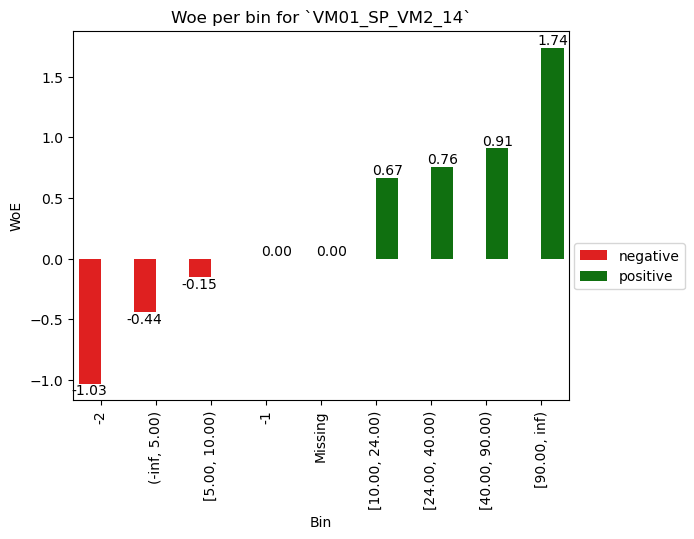

In [277]:
plot_woe_per_bin(t, col_name)

In [278]:
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([-inf,  -2.,  -1.,   5.,  10.,  24.,  40.,  90.])

In [395]:
# check the distribution of each bin and the corresponding WoEs
col_name='VM01_SP_VM2_14'
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[5, 20., 65], 
    user_splits_fixed=[True] * 3,
    special_codes={-1: -1, -2: -2}, 
    # class_weight='balanced'
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
t

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,-2,1706,0.122382,1566,140,0.082063,-1.030366,0.215247,0.025775
1,"(-inf, 5.00)",2648,0.189957,2523,125,0.047205,-0.440113,0.045446,0.005635
2,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
4,"[5.00, 20.00)",3624,0.259971,3533,91,0.025110,0.214040,0.010786,0.001346
5,"[20.00, 65.00)",4257,0.305380,4199,58,0.013625,0.837155,0.147556,0.017924
6,"[65.00, inf)",1664,0.119369,1647,17,0.010216,1.128494,0.093073,0.011054


In [396]:
pd.Series( optb.transform(df_train[col_name].values, metric="bins",)).value_counts(normalize=True)

[20.00, 65.00)    0.305380
[5.00, 20.00)     0.259971
(-inf, 5.00)      0.189957
-2                0.122382
[65.00, inf)      0.119369
-1                0.002941
Name: proportion, dtype: float64

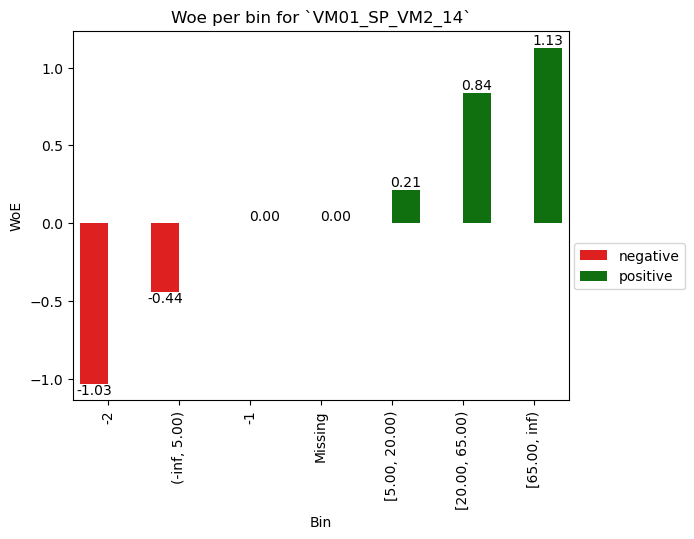

In [397]:
plot_woe_per_bin(t, col_name)

In [398]:
col_name = 'VM01_SP_VM2_14OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_name], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_name[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
5,"[65.00, inf)",104,7763,VM01_SP_VM2_14,7867,0.013220,1.137773,0.125794
1,-1,4,205,VM01_SP_VM2_14,209,0.019139,0.761755,0.003342
3,"[20.00, 65.00)",367,15385,VM01_SP_VM2_14,15752,0.023299,0.560826,0.251875
4,"[5.00, 20.00)",686,18014,VM01_SP_VM2_14,18700,0.036684,0.093067,0.299013
2,"(-inf, 5.00)",636,11548,VM01_SP_VM2_14,12184,0.052200,-0.275891,0.194822
0,-2,712,7115,VM01_SP_VM2_14,7827,0.090967,-0.873078,0.125154


In [399]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_name], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_name[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
5,"[65.00, inf)",55,1592,VM01_SP_VM2_14,1647,0.033394,1.038904,0.109822
3,"[20.00, 65.00)",176,2965,VM01_SP_VM2_14,3141,0.056033,0.497639,0.209442
4,"[5.00, 20.00)",439,4968,VM01_SP_VM2_14,5407,0.081191,0.099764,0.360539
1,-1,4,45,VM01_SP_VM2_14,49,0.081633,0.093859,0.003267
2,"(-inf, 5.00)",292,2586,VM01_SP_VM2_14,2878,0.101459,-0.145396,0.191905
0,-2,368,1507,VM01_SP_VM2_14,1875,0.196267,-0.916716,0.125025


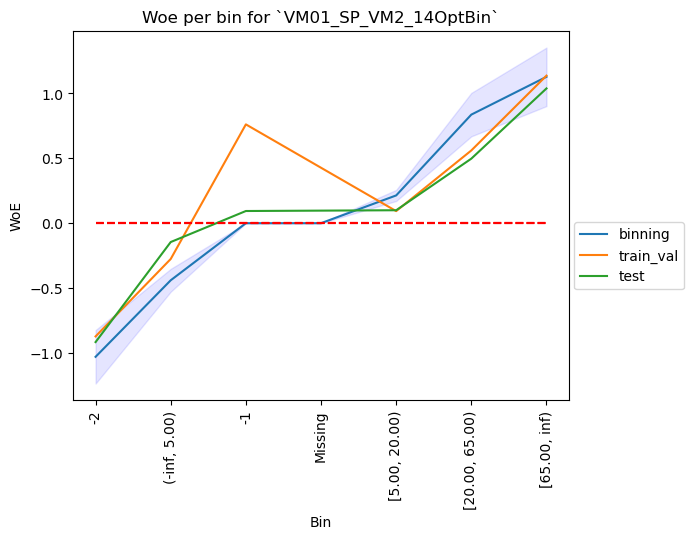

In [400]:
plot_woe_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

#### SP_G_38

In [416]:
col_name='SP_G_38'

In [417]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 38.00)",1283,0.092037,1174,109,0.084957,-1.068179,0.177313,0.021167
1,"[38.00, 48.00)",1316,0.094405,1245,71,0.053951,-0.580792,0.042149,0.005196
2,"[48.00, 58.00)",1926,0.138164,1844,82,0.042575,-0.332030,0.017848,0.002221
3,"[58.00, 64.00)",1284,0.092109,1237,47,0.036604,-0.174707,0.003054,0.000381
4,-1.0,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
5,-2.0,13,0.000933,13,0,0.000000,0.000000,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
7,"[64.00, 74.00)",2020,0.144907,1972,48,0.023762,0.270599,0.009365,0.001167
8,"[74.00, 90.00)",2429,0.174247,2384,45,0.018526,0.524869,0.037826,0.004675
9,"[90.00, 116.00)",2204,0.158106,2183,21,0.009528,1.198930,0.135326,0.015970


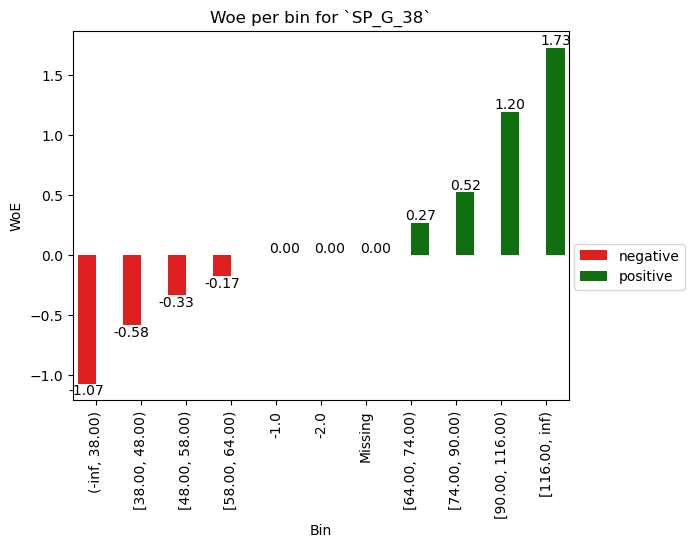

In [418]:
plot_woe_per_bin(t, col_name)

In [419]:
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([-inf,  -2.,  -1.,  38.,  48.,  58.,  64.,  74.,  90., 116.])

IV:  0.5287569567537964


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 38.00)",1283,0.092037,1174,109,0.084957,-1.068179,0.177313,0.021167
1,"[38.00, 48.00)",1316,0.094405,1245,71,0.053951,-0.580792,0.042149,0.005196
2,"[48.00, 58.00)",1926,0.138164,1844,82,0.042575,-0.332030,0.017848,0.002221
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
4,-2,13,0.000933,13,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
6,"[58.00, 74.00)",3304,0.237016,3209,95,0.028753,0.074834,0.001282,0.000160
7,"[74.00, 100.00)",3497,0.250861,3443,54,0.015442,0.710111,0.092014,0.011266
8,"[100.00, inf)",2560,0.183644,2540,20,0.007812,1.399184,0.198151,0.022928


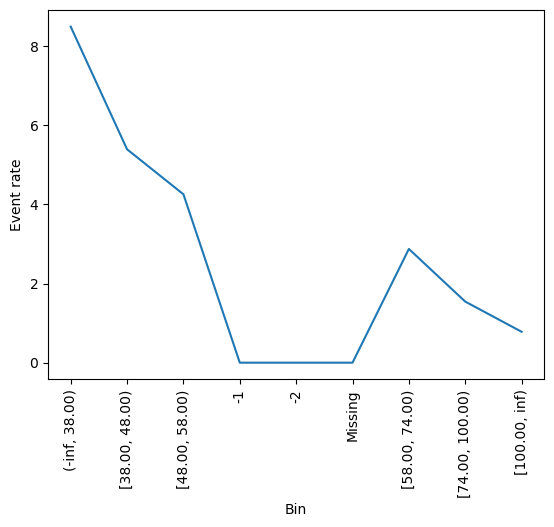

In [465]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[38.,  48.,  58.,  74.,  100], 
    user_splits_fixed=[True] * 5,
    special_codes={-1: -1, -2: -2}, 
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
_ = sns.lineplot(x=t.Bin.astype(str), y=t['Event rate'] * 100)
_ = plt.xticks(rotation=90)
t

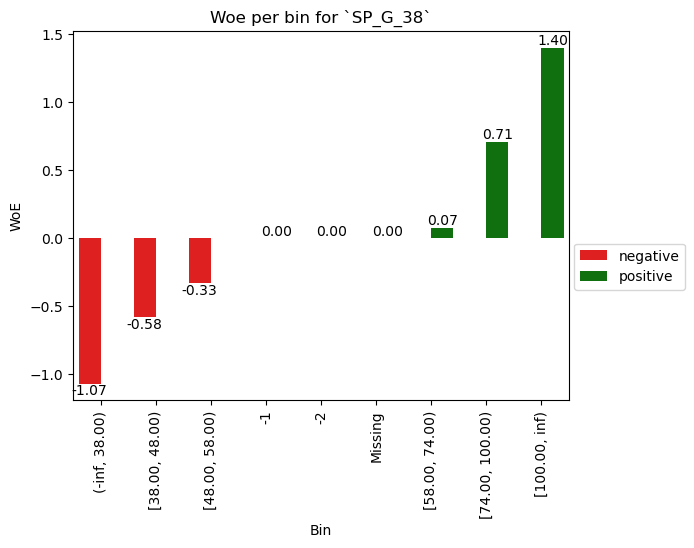

In [466]:
plot_woe_per_bin(t, col_name)

In [467]:
col_alias = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_alias], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
3,"[100.00, inf)",162,11017,SP_G_38,11179,0.014491,1.044638,0.178752
1,-1,4,205,SP_G_38,209,0.019139,0.761755,0.003342
7,"[74.00, 100.00)",367,14635,SP_G_38,15002,0.024463,0.510849,0.239882
6,"[58.00, 74.00)",548,13984,SP_G_38,14532,0.037710,0.064434,0.232367
5,"[48.00, 58.00)",435,8301,SP_G_38,8736,0.049794,-0.226175,0.139689
4,"[38.00, 48.00)",407,5798,SP_G_38,6205,0.065592,-0.518505,0.099218
2,"(-inf, 38.00)",579,6035,SP_G_38,6614,0.087542,-0.830932,0.105758
0,-2,7,55,SP_G_38,62,0.112903,-1.113537,0.000991


In [468]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_alias], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
3,"[100.00, inf)",106,2100,SP_G_38,2206,0.048051,0.659744,0.147096
7,"[74.00, 100.00)",195,3131,SP_G_38,3326,0.058629,0.449599,0.221778
6,"[58.00, 74.00)",264,3179,SP_G_38,3443,0.076677,0.161863,0.229579
1,-1,4,45,SP_G_38,49,0.081633,0.093859,0.003267
5,"[48.00, 58.00)",211,2063,SP_G_38,2274,0.092788,-0.046451,0.151630
4,"[38.00, 48.00)",223,1451,SP_G_38,1674,0.133214,-0.453673,0.111622
2,"(-inf, 38.00)",327,1690,SP_G_38,2017,0.162122,-0.683986,0.134494
0,-2,4,4,SP_G_38,8,0.500000,-2.326510,0.000533


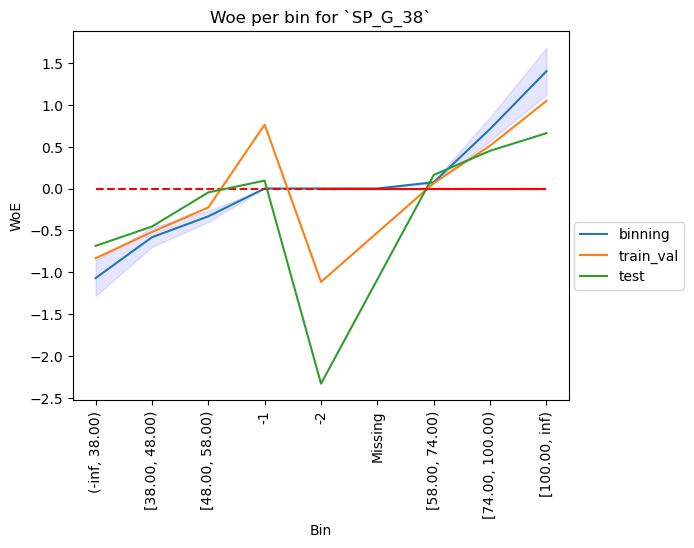

In [469]:
plot_woe_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

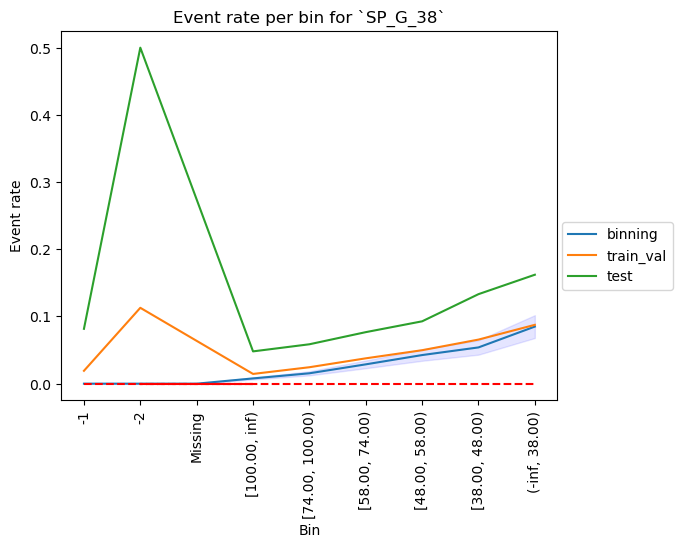

In [470]:
plot_er_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

#### SP_B1_14

In [471]:
col_name='SP_B1_14'

In [472]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

IV:  0.36753884592946784


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,-2.0,701,0.050287,612,89,0.126961,-1.516907,0.244515,0.027935
1,-1.0,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
2,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
3,"(-inf, 2.00)",9521,0.682999,9230,291,0.030564,0.011888,0.000096,0.000012
4,"[2.00, inf)",3677,0.263773,3626,51,0.013870,0.819056,0.122927,0.014950


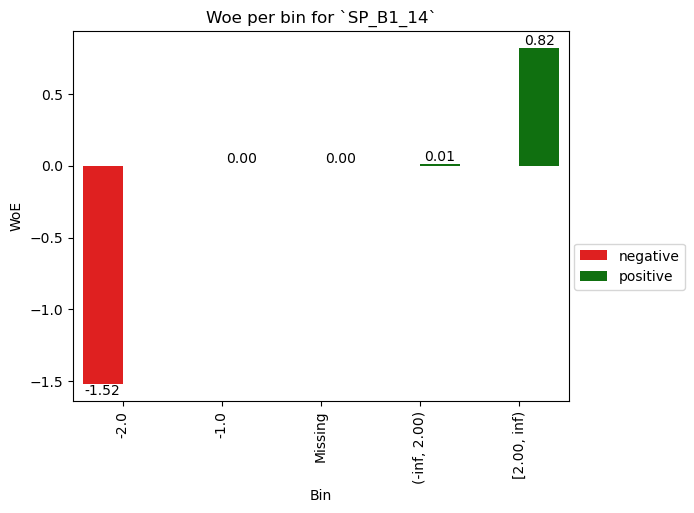

In [473]:
plot_woe_per_bin(t, col_name)

In [474]:
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([-inf,  -2.,  -1.,   2.])

IV:  0.30884078883879906


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,-2,701,0.050287,612,89,0.126961,-1.516907,0.244515,0.027935
1,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
2,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
3,"(-inf, 3.00)",11558,0.829125,11239,319,0.027600,0.116951,0.010739,0.001342
4,"[3.00, inf)",1640,0.117647,1617,23,0.014024,0.807830,0.053586,0.006522


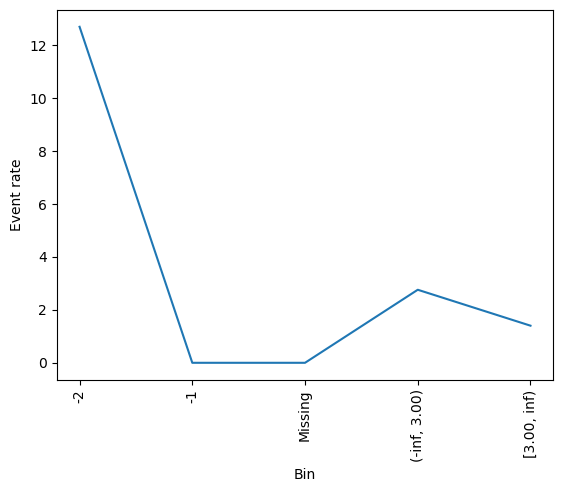

In [483]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[3], 
    user_splits_fixed=[True],
    special_codes={-1: -1, -2: -2}, 
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
_ = sns.lineplot(x=t.Bin.astype(str), y=t['Event rate'] * 100)
_ = plt.xticks(rotation=90)
t

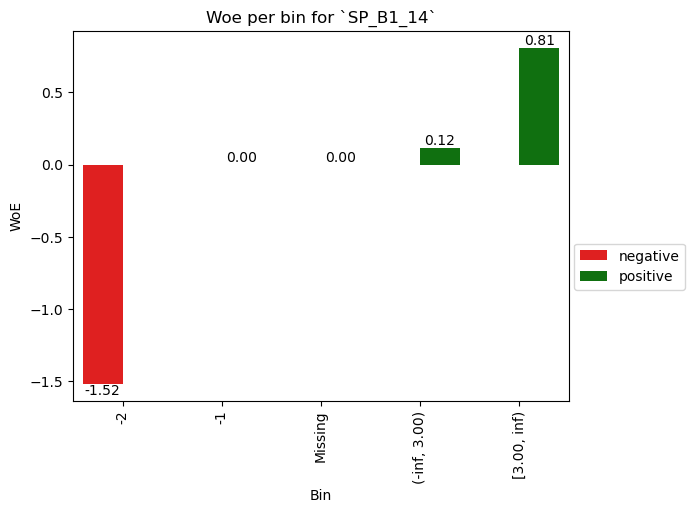

In [477]:
plot_woe_per_bin(t, col_name)

In [478]:
col_alias = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_alias], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
1,-1,4,205,SP_B1_14,209,0.019139,0.761755,0.003342
3,"[3.00, inf)",225,7985,SP_B1_14,8210,0.027406,0.394259,0.131278
2,"(-inf, 3.00)",1870,49262,SP_B1_14,51132,0.036572,0.096254,0.817602
0,-2,410,2578,SP_B1_14,2988,0.137216,-1.336348,0.047778


In [479]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_alias], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
3,"[3.00, inf)",121,2280,SP_B1_14,2401,0.050396,0.609631,0.160099
1,-1,4,45,SP_B1_14,49,0.081633,0.093859,0.003267
2,"(-inf, 3.00)",1042,10790,SP_B1_14,11832,0.088066,0.010968,0.788958
0,-2,167,548,SP_B1_14,715,0.233566,-1.138228,0.047676


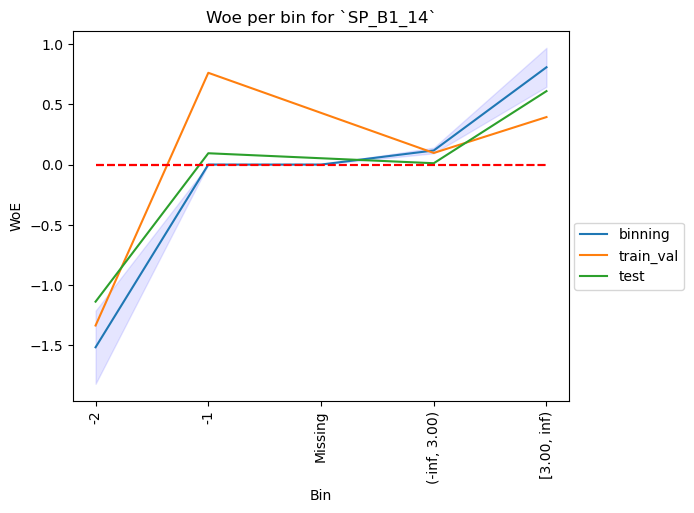

In [480]:
plot_woe_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

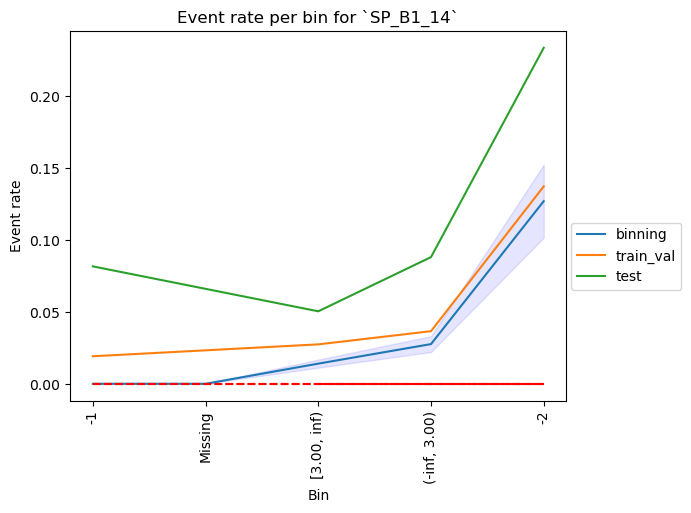

In [481]:
plot_er_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

#### GEN11_SP_N_91

In [590]:
col_name='GEN11_SP_N_91'

In [591]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

IV:  0.36546322081868193


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 800.00)",1558,0.111765,1450,108,0.069320,-0.847816,0.121445,0.014742
1,"[800.00, 2500.00)",6417,0.460330,6177,240,0.037401,-0.197054,0.019625,0.002449
2,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
3,-2,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,"[2500.00, 3400.00)",3035,0.217719,2980,55,0.018122,0.547342,0.050894,0.006283
6,"[3400.00, inf)",2889,0.207245,2861,28,0.009692,1.181719,0.173499,0.020508


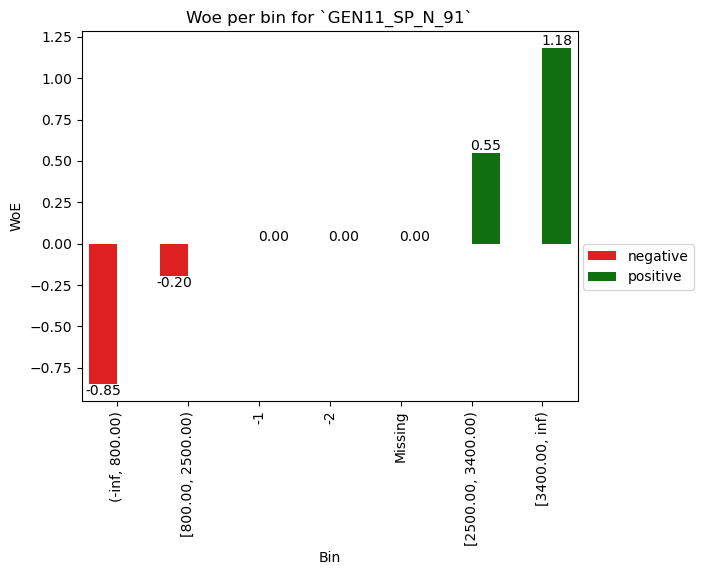

In [592]:
plot_woe_per_bin(t, col_name)

In [593]:
np.set_printoptions(suppress=True)
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([ -inf,   -2.,   -1.,  800., 2500., 3400.])

IV:  0.36546322081868193


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 800.00)",1558,0.111765,1450,108,0.069320,-0.847816,0.121445,0.014742
1,"[800.00, 2500.00)",6417,0.460330,6177,240,0.037401,-0.197054,0.019625,0.002449
2,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
3,-2,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,"[2500.00, 3400.00)",3035,0.217719,2980,55,0.018122,0.547342,0.050894,0.006283
6,"[3400.00, inf)",2889,0.207245,2861,28,0.009692,1.181719,0.173499,0.020508


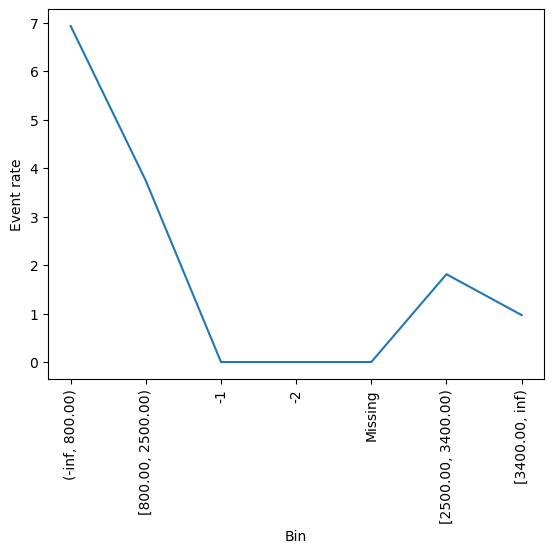

In [611]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[ 800., 2500., 3400.], 
    user_splits_fixed=[True]*3,
    special_codes={-1: -1, -2: -2}, 
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
_ = sns.lineplot(x=t.Bin.astype(str), y=t['Event rate'] * 100)
_ = plt.xticks(rotation=90)
t

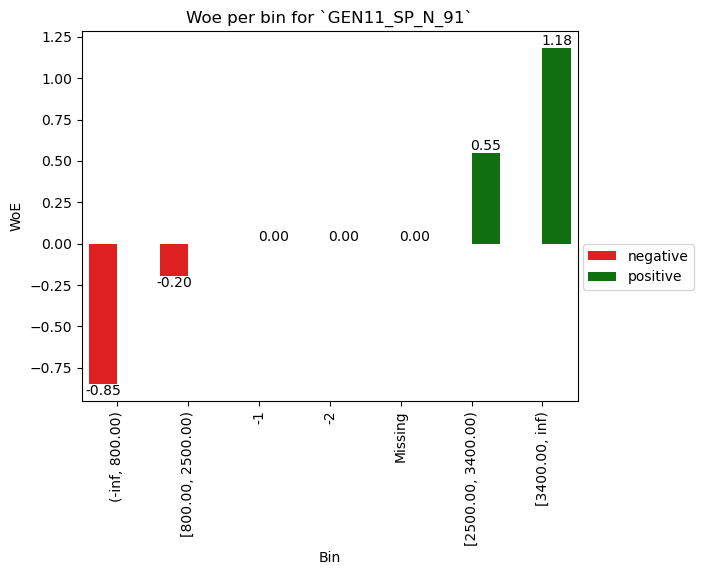

In [612]:
plot_woe_per_bin(t, col_name)

In [613]:
col_alias = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_alias], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
3,"[3400.00, inf)",247,13584,GEN11_SP_N_91,13831,0.017858,0.832299,0.221158
0,-1,4,205,GEN11_SP_N_91,209,0.019139,0.761755,0.003342
2,"[2500.00, 3400.00)",373,13244,GEN11_SP_N_91,13617,0.027392,0.394761,0.217736
4,"[800.00, 2500.00)",1370,27074,GEN11_SP_N_91,28444,0.048165,-0.191197,0.454820
1,"(-inf, 800.00)",515,5923,GEN11_SP_N_91,6438,0.079994,-0.732529,0.102944


In [614]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_alias], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
3,"[3400.00, inf)",125,3202,GEN11_SP_N_91,3327,0.037571,0.916708,0.221844
2,"[2500.00, 3400.00)",185,2821,GEN11_SP_N_91,3006,0.061544,0.397981,0.200440
0,-1,4,45,GEN11_SP_N_91,49,0.081633,0.093859,0.003267
4,"[800.00, 2500.00)",776,6158,GEN11_SP_N_91,6934,0.111912,-0.255155,0.462359
1,"(-inf, 800.00)",244,1437,GEN11_SP_N_91,1681,0.145152,-0.553365,0.112089


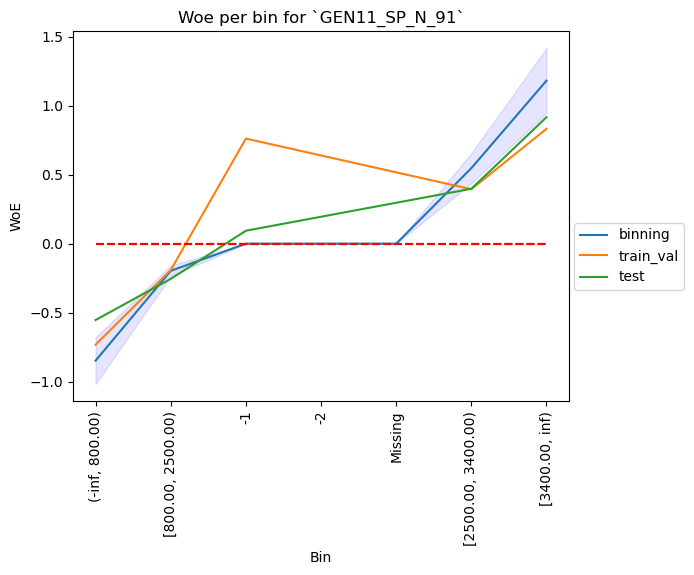

In [615]:
plot_woe_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

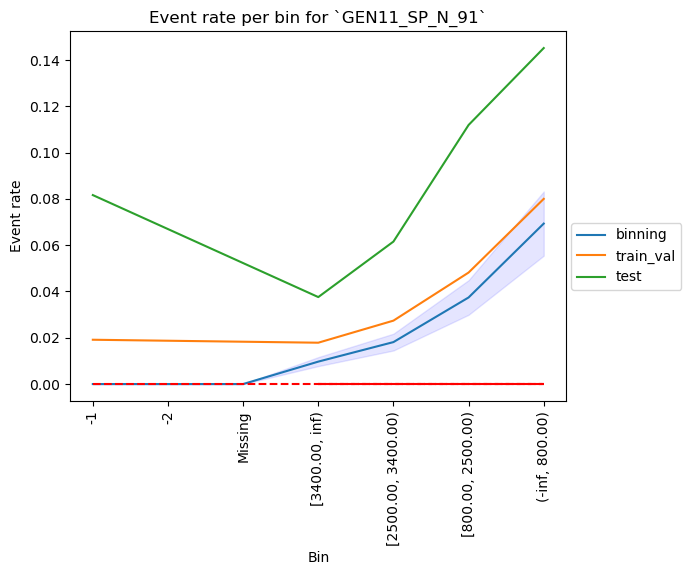

In [616]:
plot_er_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

#### GEN11_SP_EDI_07

In [621]:
col_name='GEN11_SP_EDI_07'

In [622]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

IV:  0.3299745626797248


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 450.00)",1546,0.110904,1448,98,0.063389,-0.752032,0.090387,0.011039
1,"[450.00, 512.00)",937,0.067217,881,56,0.059765,-0.689297,0.044608,0.005468
2,"[512.00, 678.00)",2242,0.160832,2152,90,0.040143,-0.270660,0.013402,0.001670
3,-1.0,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,"[678.00, 812.00)",2071,0.148565,2010,61,0.029454,0.050013,0.000363,0.000045
6,"[812.00, 862.00)",872,0.062554,850,22,0.025229,0.209191,0.002485,0.000310
7,"[862.00, 974.00)",1981,0.142109,1933,48,0.024230,0.250624,0.007950,0.000991
8,"[974.00, 1028.00)",791,0.056743,775,16,0.020228,0.435271,0.008813,0.001093
9,"[1028.00, 1164.00)",1332,0.095552,1315,17,0.012763,0.903375,0.052305,0.006324


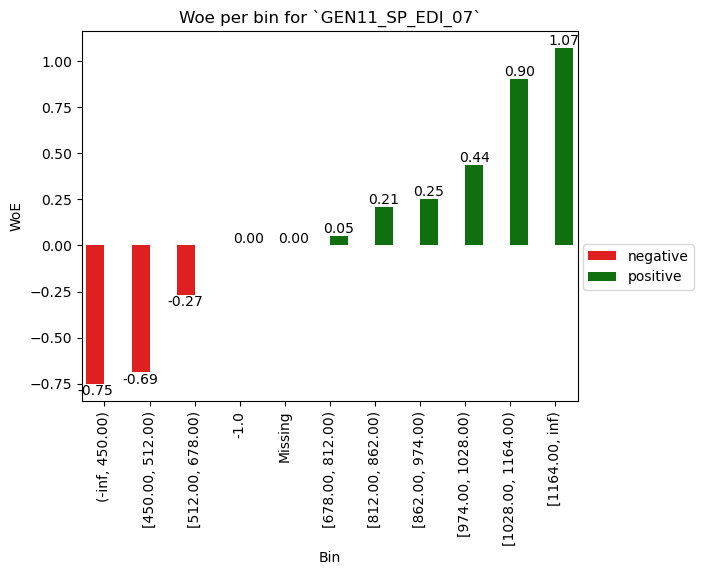

In [623]:
plot_woe_per_bin(t, col_name)

In [624]:
np.set_printoptions(suppress=True)
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([ -inf,   -1.,  450.,  512.,  678.,  812.,  862.,  974., 1028.,
       1164.])

IV:  0.3080268436244435


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 500.00)",2368,0.169871,2220,148,0.062500,-0.736953,0.131953,0.016131
1,"[500.00, 700.00)",2692,0.193113,2590,102,0.037890,-0.210563,0.009462,0.001181
2,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
3,-2,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,"[700.00, 950.00)",4234,0.303730,4118,116,0.027397,0.124529,0.004445,0.000555
6,"[950.00, 1150.00)",2374,0.170301,2333,41,0.017270,0.596335,0.046259,0.005698
7,"[1150.00, inf)",2231,0.160043,2207,24,0.010758,1.076332,0.115908,0.013827


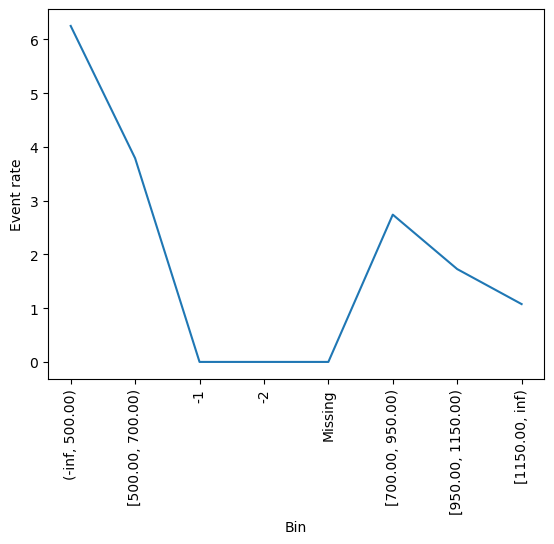

In [706]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[500., 700, 950, 1150.], 
    user_splits_fixed=[True]*4,
    special_codes={-1: -1, -2: -2}, 
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
_ = sns.lineplot(x=t.Bin.astype(str), y=t['Event rate'] * 100)
_ = plt.xticks(rotation=90)
t

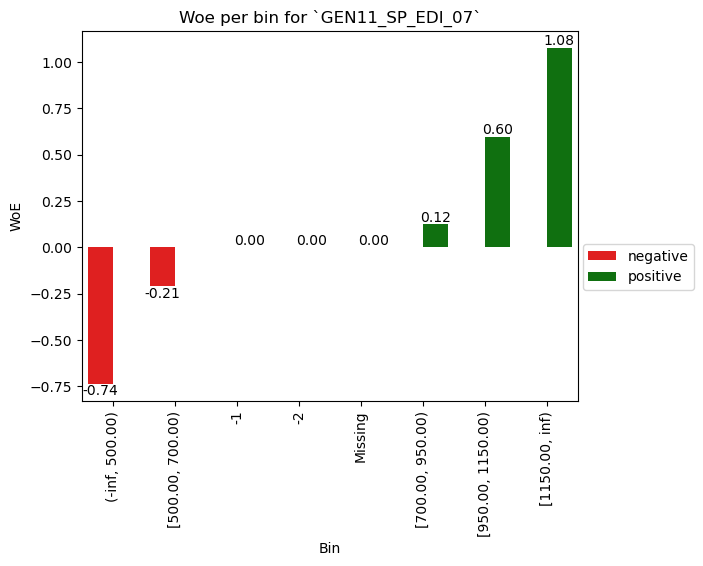

In [707]:
plot_woe_per_bin(t, col_name)

In [708]:
col_alias = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_alias], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
2,"[1150.00, inf)",192,10045,GEN11_SP_EDI_07,10237,0.018755,0.782375,0.163690
0,-1,4,205,GEN11_SP_EDI_07,209,0.019139,0.761755,0.003342
5,"[950.00, 1150.00)",303,10467,GEN11_SP_EDI_07,10770,0.028134,0.367290,0.172213
4,"[700.00, 950.00)",585,17816,GEN11_SP_EDI_07,18401,0.031792,0.241280,0.294232
3,"[500.00, 700.00)",749,12293,GEN11_SP_EDI_07,13042,0.057430,-0.376914,0.208542
1,"(-inf, 500.00)",676,9204,GEN11_SP_EDI_07,9880,0.068421,-0.563760,0.157981


In [709]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_alias], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
2,"[1150.00, inf)",46,2213,GEN11_SP_EDI_07,2259,0.020363,1.546953,0.150630
5,"[950.00, 1150.00)",135,2203,GEN11_SP_EDI_07,2338,0.057742,0.465791,0.155898
4,"[700.00, 950.00)",275,3694,GEN11_SP_EDI_07,3969,0.069287,0.271185,0.264653
0,-1,4,45,GEN11_SP_EDI_07,49,0.081633,0.093859,0.003267
3,"[500.00, 700.00)",516,3288,GEN11_SP_EDI_07,3804,0.135647,-0.474582,0.253651
1,"(-inf, 500.00)",358,2220,GEN11_SP_EDI_07,2578,0.138867,-0.501780,0.171901


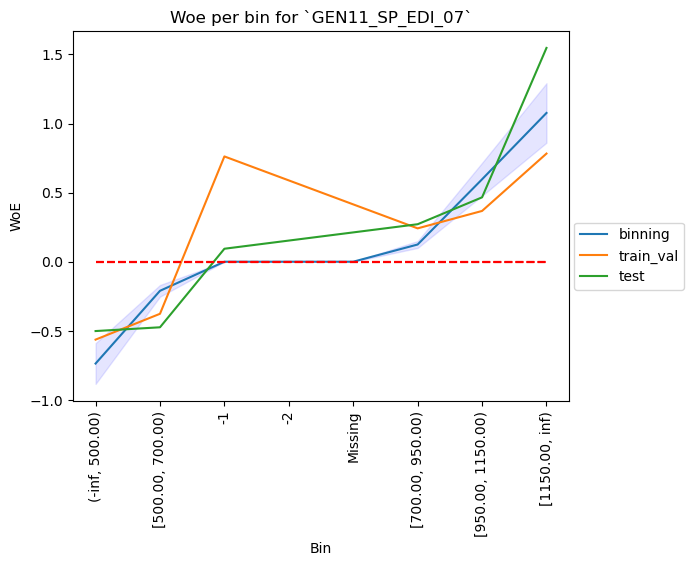

In [710]:
plot_woe_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

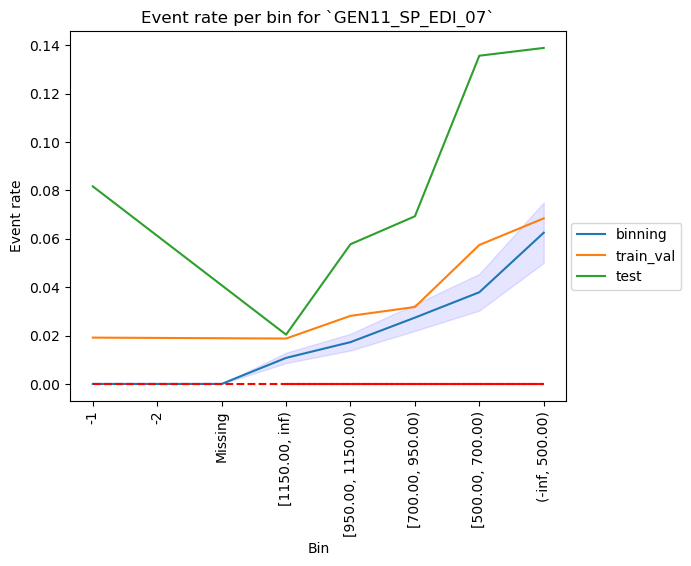

In [711]:
plot_er_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

#### VM01_SP_VM2_15

In [732]:
col_name='VM01_SP_VM2_15'

In [733]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

IV:  1.0056291795593606


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,-2.0,1706,0.122382,1566,140,0.082063,-1.030366,0.215247,0.025775
1,"(-inf, 16.00)",2286,0.163989,2148,138,0.060367,-0.699965,0.112821,0.013822
2,"[16.00, 24.00)",791,0.056743,764,27,0.034134,-0.102272,0.000623,0.000078
3,"[24.00, 40.00)",1633,0.117145,1578,55,0.033680,-0.088423,0.000955,0.000119
4,-1.0,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
6,"[40.00, 60.00)",1681,0.120588,1645,36,0.021416,0.376973,0.014417,0.001792
7,"[60.00, 92.00)",1807,0.129627,1786,21,0.011621,0.998208,0.083335,0.010005
8,"[92.00, inf)",3995,0.286585,3981,14,0.003504,2.205228,0.578232,0.060469


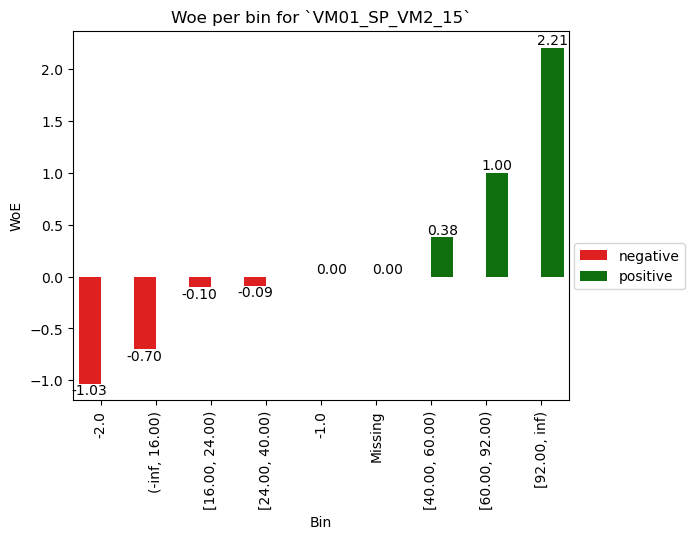

In [734]:
plot_woe_per_bin(t, col_name)

In [735]:
np.set_printoptions(suppress=True)
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([-inf,  -2.,  -1.,  16.,  24.,  40.,  60.,  92.])

In [763]:
12*8

96

IV:  0.9077775671300974


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,-2,1706,0.122382,1566,140,0.082063,-1.030366,0.215247,0.025775
1,"(-inf, 12.00)",2068,0.148350,1940,128,0.061896,-0.726590,0.111441,0.013632
2,"[12.00, 36.00)",2290,0.164275,2213,77,0.033624,-0.086704,0.001286,0.000161
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,"[36.00, 60.00)",2033,0.145839,1982,51,0.025086,0.215033,0.006104,0.000762
6,"[60.00, inf)",5802,0.416212,5767,35,0.006032,1.659556,0.573699,0.064472


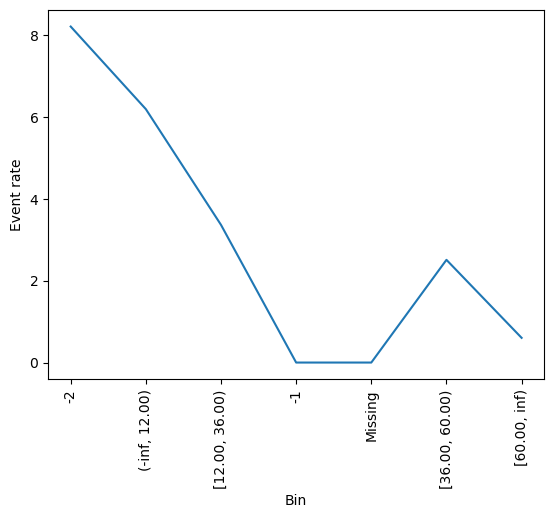

In [773]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[12.,  36., 60.], 
    user_splits_fixed=[True]*3,
    special_codes={-1: -1, -2: -2}, 
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
_ = sns.lineplot(x=t.Bin.astype(str), y=t['Event rate'] * 100)
_ = plt.xticks(rotation=90)
t

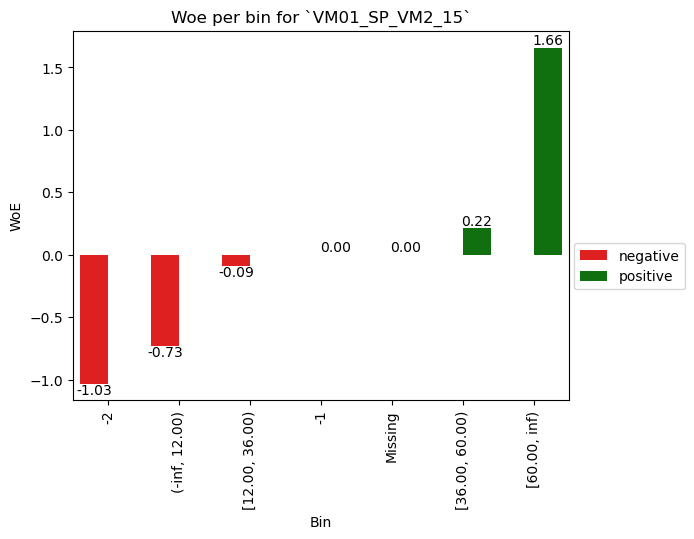

In [774]:
plot_woe_per_bin(t, col_name)

In [775]:
col_alias = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_alias], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
5,"[60.00, inf)",391,25937,VM01_SP_VM2_15,26328,0.014851,1.019758,0.420985
1,-1,4,205,VM01_SP_VM2_15,209,0.019139,0.761755,0.003342
4,"[36.00, 60.00)",326,8918,VM01_SP_VM2_15,9244,0.035266,0.133969,0.147812
3,"[12.00, 36.00)",448,8796,VM01_SP_VM2_15,9244,0.048464,-0.197701,0.147812
2,"(-inf, 12.00)",628,9059,VM01_SP_VM2_15,9687,0.064829,-0.505986,0.154895
0,-2,712,7115,VM01_SP_VM2_15,7827,0.090967,-0.873078,0.125154


In [776]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_alias], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
5,"[60.00, inf)",213,5716,VM01_SP_VM2_15,5929,0.035925,0.963223,0.395346
4,"[36.00, 60.00)",159,1910,VM01_SP_VM2_15,2069,0.076849,0.159445,0.137961
1,-1,4,45,VM01_SP_VM2_15,49,0.081633,0.093859,0.003267
3,"[12.00, 36.00)",278,2319,VM01_SP_VM2_15,2597,0.107047,-0.205239,0.173168
2,"(-inf, 12.00)",312,2166,VM01_SP_VM2_15,2478,0.125908,-0.388875,0.165233
0,-2,368,1507,VM01_SP_VM2_15,1875,0.196267,-0.916716,0.125025


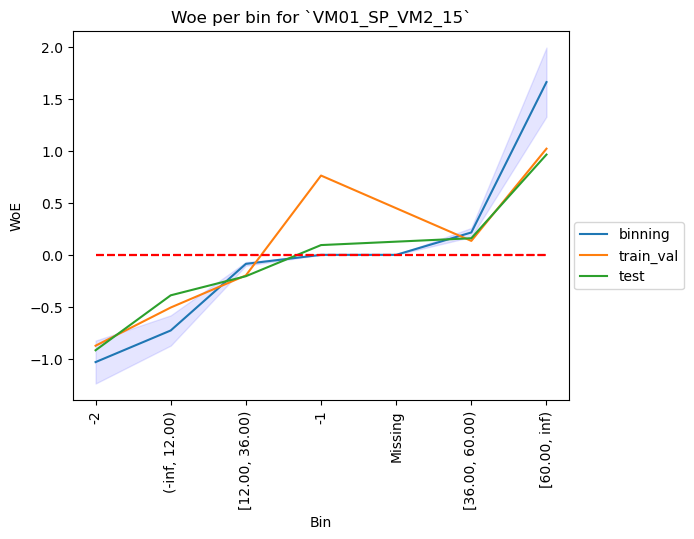

In [777]:
plot_woe_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

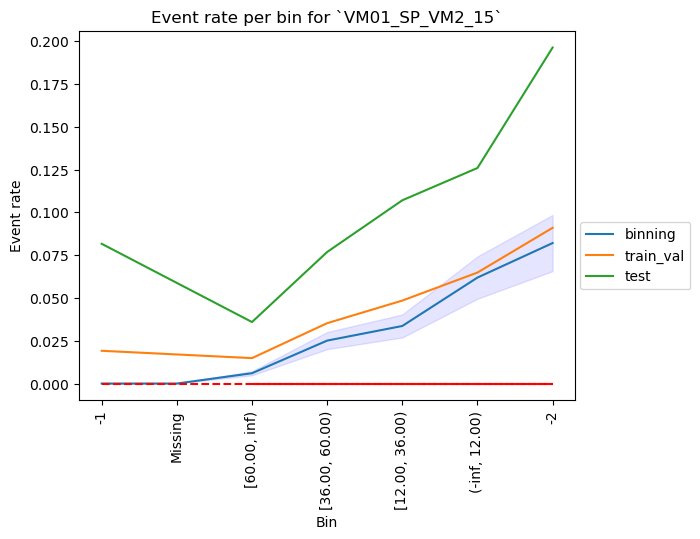

In [778]:
plot_er_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

#### SP_G_37

In [783]:
col_name='SP_G_37'

In [784]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

IV:  0.7067033605252219


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 94.00)",1511,0.108393,1383,128,0.084712,-1.065023,0.207262,0.024749
1,"[94.00, 122.00)",1269,0.091033,1183,86,0.067770,-0.823542,0.092208,0.011211
2,"[122.00, 144.00)",1182,0.084792,1126,56,0.047377,-0.443928,0.020678,0.002564
3,"[144.00, 160.00)",936,0.067145,906,30,0.032051,-0.037161,0.000094,0.000012
4,-1.0,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
5,-2.0,13,0.000933,13,0,0.000000,0.000000,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
7,"[160.00, 206.00)",3063,0.219727,2998,65,0.021221,0.386310,0.027472,0.003413
8,"[206.00, 270.00)",3184,0.228407,3134,50,0.015704,0.693039,0.080382,0.009851
9,"[270.00, 292.00)",674,0.048350,670,4,0.005935,1.675980,0.067569,0.007578


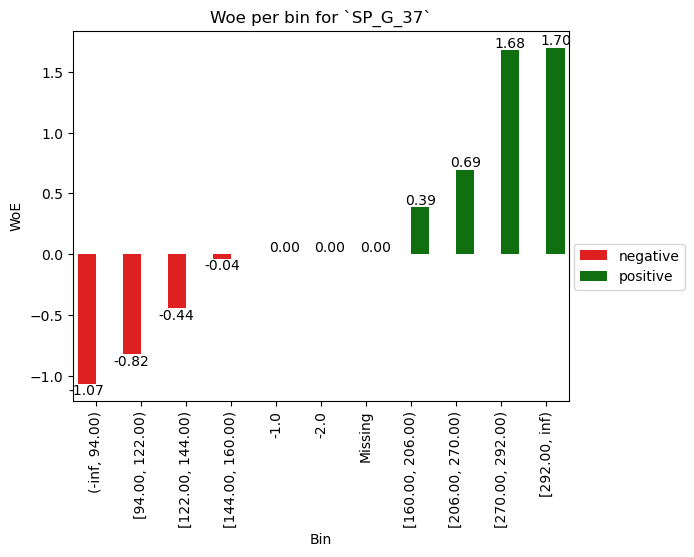

In [785]:
plot_woe_per_bin(t, col_name)

In [786]:
np.set_printoptions(suppress=True)
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([-inf,  -2.,  -1.,  94., 122., 144., 160., 206., 270., 292.])

In [ ]:
144-160

IV:  0.6976097818536465


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 94.00)",1511,0.108393,1383,128,0.084712,-1.065023,0.207262,0.024749
1,"[94.00, 122.00)",1269,0.091033,1183,86,0.067770,-0.823542,0.092208,0.011211
2,"[122.00, 150.00)",1519,0.108967,1452,67,0.044108,-0.368999,0.017700,0.002200
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
4,-2,13,0.000933,13,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
6,"[150.00, 206.00)",3662,0.262697,3578,84,0.022938,0.306739,0.021461,0.002672
7,"[206.00, 270.00)",3184,0.228407,3134,50,0.015704,0.693039,0.080382,0.009851
8,"[270.00, inf)",2741,0.196628,2725,16,0.005837,1.692632,0.278598,0.031185


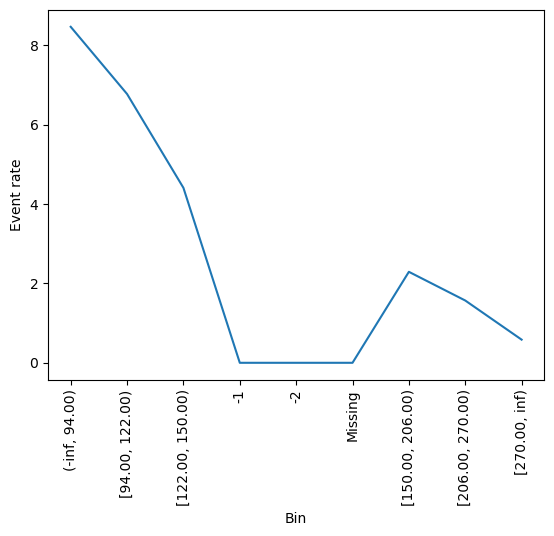

In [809]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[ 94., 122., 150, 206., 270.], 
    user_splits_fixed=[True]*5,
    special_codes={-1: -1, -2: -2}, 
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
_ = sns.lineplot(x=t.Bin.astype(str), y=t['Event rate'] * 100)
_ = plt.xticks(rotation=90)
t

In [810]:
col_alias = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_alias], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
6,"[270.00, inf)",156,12434,SP_G_37,12590,0.012391,1.203374,0.201314
1,-1,4,205,SP_G_37,209,0.019139,0.761755,0.003342
5,"[206.00, 270.00)",332,13622,SP_G_37,13954,0.023792,0.539346,0.223125
4,"[150.00, 206.00)",565,15095,SP_G_37,15660,0.036079,0.110333,0.250404
3,"[122.00, 150.00)",346,6224,SP_G_37,6570,0.052664,-0.285231,0.105054
7,"[94.00, 122.00)",389,5514,SP_G_37,5903,0.065899,-0.523494,0.094389
2,"(-inf, 94.00)",710,6881,SP_G_37,7591,0.093532,-0.903706,0.121380
0,-2,7,55,SP_G_37,62,0.112903,-1.113537,0.000991


In [811]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_alias], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
6,"[270.00, inf)",109,2659,SP_G_37,2768,0.039379,0.867848,0.184570
5,"[206.00, 270.00)",163,2982,SP_G_37,3145,0.051828,0.580090,0.209709
4,"[150.00, 206.00)",273,3255,SP_G_37,3528,0.077381,0.151966,0.235247
1,-1,4,45,SP_G_37,49,0.081633,0.093859,0.003267
3,"[122.00, 150.00)",180,1554,SP_G_37,1734,0.103806,-0.170879,0.115623
7,"[94.00, 122.00)",207,1336,SP_G_37,1543,0.134154,-0.461793,0.102887
2,"(-inf, 94.00)",394,1828,SP_G_37,2222,0.177318,-0.791883,0.148163
0,-2,4,4,SP_G_37,8,0.500000,-2.326510,0.000533


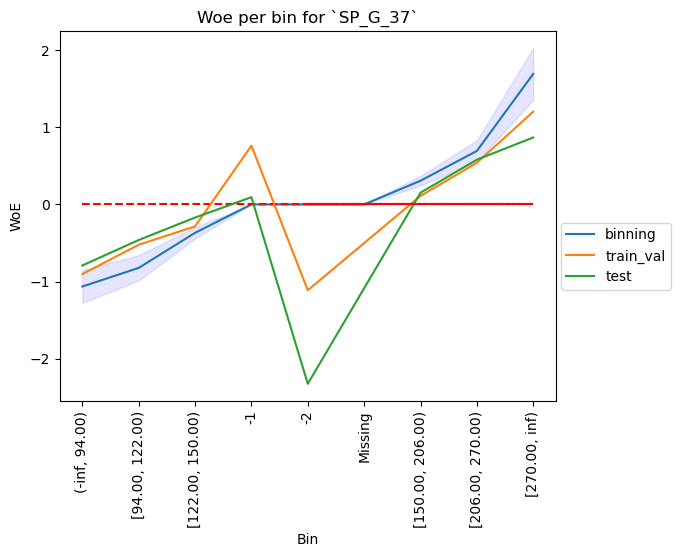

In [812]:
plot_woe_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

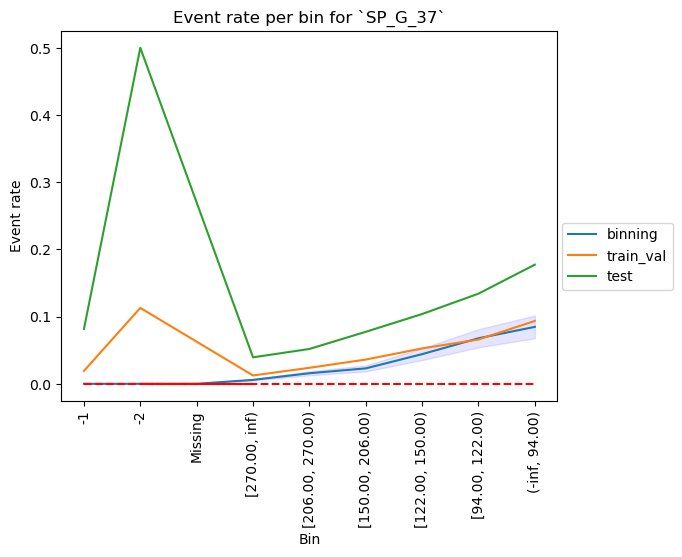

In [813]:
plot_er_per_bin_by_df(
    data_dict={
        'binning': t,
        'train_val': df_train_bin_sts,
        'test': df_test_bin_sts
    },
    col_name=col_name
)

#### TRD_C_07

In [823]:
col_name='TRD_C_07'

In [824]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

IV:  0.163805320918387


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[95.00, inf)",413,0.029627,391,22,0.053269,-0.567338,0.012538,0.001547
1,"(-inf, 40.00)",10070,0.722382,9715,355,0.035253,-0.135695,0.014182,0.001771
2,"[86.00, 95.00)",631,0.045265,611,20,0.031696,-0.025639,0.000030,0.000004
3,-1,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
4,-2,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
6,"[62.00, 86.00)",1488,0.106743,1465,23,0.015457,0.709113,0.039059,0.004783
7,"[40.00, 62.00)",1338,0.095983,1327,11,0.008221,1.347777,0.097995,0.011399


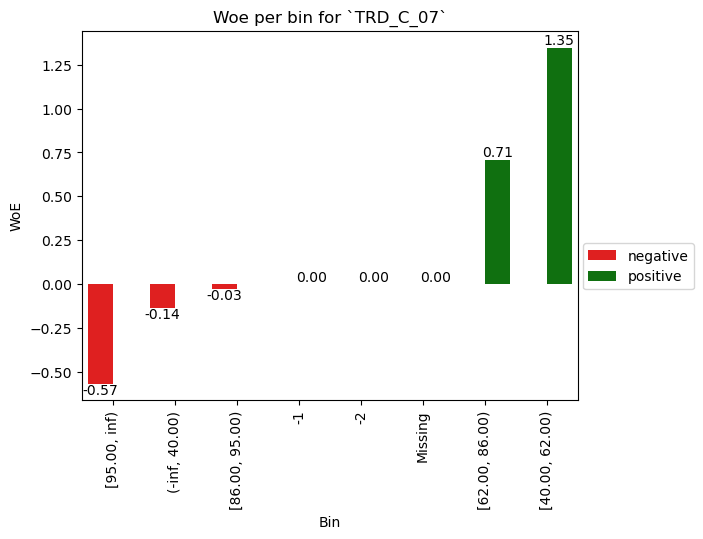

In [825]:
plot_woe_per_bin(t, col_name)

In [826]:
np.set_printoptions(suppress=True)
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([-inf,  -2.,  -1.,  40.,  62.,  86.,  95.])

IV:  0.5552184854866892


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,-999998,1752,0.125681,1609,143,0.081621,-1.024480,0.217887,0.026104
1,"[95.00, inf)",413,0.029627,391,22,0.053269,-0.567338,0.012538,0.001547
2,-999996,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
3,-999999,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,-999997,6625,0.475251,6421,204,0.030792,0.004206,0.000008,0.000001
6,"[80.00, 95.00)",998,0.071593,972,26,0.026052,0.176256,0.002049,0.000256
7,"[62.00, 80.00)",1121,0.080416,1104,17,0.015165,0.728479,0.030800,0.003767
8,"[40.00, 62.00)",1338,0.095983,1327,11,0.008221,1.347777,0.097995,0.011399
9,"(-inf, 40.00)",1652,0.118508,1644,8,0.004843,1.880443,0.193940,0.021203


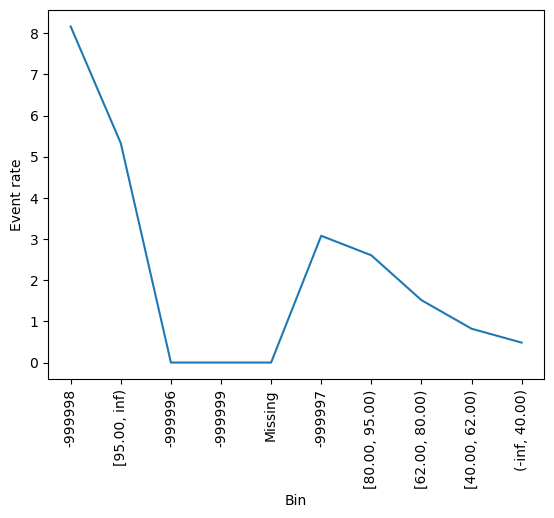

In [833]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[40, 62, 80, 95], 
    user_splits_fixed=[True]*4,
    special_codes=dict(zip(
        [
            -999996,
            -999997,
            -999998,
            -999999
        ], 
        [
            -999996,
            -999997,
            -999998,
            -999999
        ]
    )
                      )
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
_ = sns.lineplot(x=t.Bin.astype(str), y=t['Event rate'] * 100)
_ = plt.xticks(rotation=90)
t

In [834]:
col_alias = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_alias], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
4,"(-inf, 40.00)",58,6257,TRD_C_07,6315,0.009184,1.506053,0.100977
5,"[40.00, 62.00)",85,5420,TRD_C_07,5505,0.015441,0.980240,0.088025
0,-999999,4,205,TRD_C_07,209,0.019139,0.761755,0.003342
6,"[62.00, 80.00)",112,4729,TRD_C_07,4841,0.023136,0.568010,0.077408
7,"[80.00, 95.00)",169,4538,TRD_C_07,4707,0.035904,0.115383,0.075265
2,-999997,1184,29225,TRD_C_07,30409,0.038936,0.031166,0.486241
8,"[95.00, inf)",157,2407,TRD_C_07,2564,0.061232,-0.445070,0.040998
1,-999998,739,7243,TRD_C_07,7982,0.092583,-0.892467,0.127632
3,-999996,1,6,TRD_C_07,7,0.142857,-1.383201,0.000112


In [835]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_alias], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
3,"(-inf, 40.00)",28,1239,TRD_C_07,1267,0.022099,1.463346,0.084484
4,"[40.00, 62.00)",35,1206,TRD_C_07,1241,0.028203,1.213207,0.082750
5,"[62.00, 80.00)",60,1201,TRD_C_07,1261,0.047581,0.670056,0.084083
6,"[80.00, 95.00)",89,1310,TRD_C_07,1399,0.063617,0.362637,0.093285
0,-999999,4,45,TRD_C_07,49,0.081633,0.093859,0.003267
2,-999997,634,6240,TRD_C_07,6874,0.092232,-0.039823,0.458358
7,"[95.00, inf)",101,842,TRD_C_07,943,0.107105,-0.205850,0.062879
1,-999998,383,1580,TRD_C_07,1963,0.195110,-0.909364,0.130893


#### ND_ECC_06

In [846]:
col_name='ND_ECC_06'

In [847]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
t = build_woe_table(optb)
t

IV:  0.4759915641102435


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.00)",1059,0.075968,981,78,0.073654,-0.913140,0.098944,0.011955
1,"[2.00, 12.00)",1526,0.109469,1425,101,0.066186,-0.798197,0.102850,0.012526
2,"[12.00, 32.00)",1746,0.125251,1665,81,0.046392,-0.421872,0.027288,0.003386
3,-1.0,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,"[32.00, 54.00)",1135,0.081420,1103,32,0.028194,0.095050,0.000704,0.000088
6,"[54.00, 84.00)",1100,0.078910,1075,25,0.022727,0.316197,0.006821,0.000849
7,"[84.00, 164.00)",1839,0.131923,1799,40,0.021751,0.361103,0.014575,0.001812
8,"[164.00, 212.00)",851,0.061047,837,14,0.016451,0.645763,0.019035,0.002339
9,"[212.00, 400.00)",2119,0.152009,2085,34,0.016045,0.671160,0.050643,0.006214


In [849]:
np.set_printoptions(suppress=True)
np.sort(t[t.Bin != 'Missing'].Bin.apply(lambda x: str(x).split(', ')[0][1:] if len(str(x).split(', ')) > 1 else x).astype(float).values)

array([-inf,  -1.,   2.,  12.,  32.,  54.,  84., 164., 212., 400., 646.])

IV:  0.4620118544174743


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.00)",1059,0.075968,981,78,0.073654,-0.913140,0.098944,0.011955
1,"[2.00, 12.00)",1526,0.109469,1425,101,0.066186,-0.798197,0.102850,0.012526
2,"[12.00, 54.00)",2881,0.206671,2768,113,0.039222,-0.246511,0.014120,0.001761
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,"[54.00, 164.00)",2939,0.210832,2874,65,0.022116,0.344069,0.021310,0.002651
6,"[164.00, 400.00)",2970,0.213056,2922,48,0.016162,0.663819,0.069655,0.008551
7,"[400.00, 646.00)",1426,0.102296,1407,19,0.013324,0.859773,0.051646,0.006264
8,"[646.00, inf)",1098,0.078766,1091,7,0.006375,1.603937,0.103485,0.011706


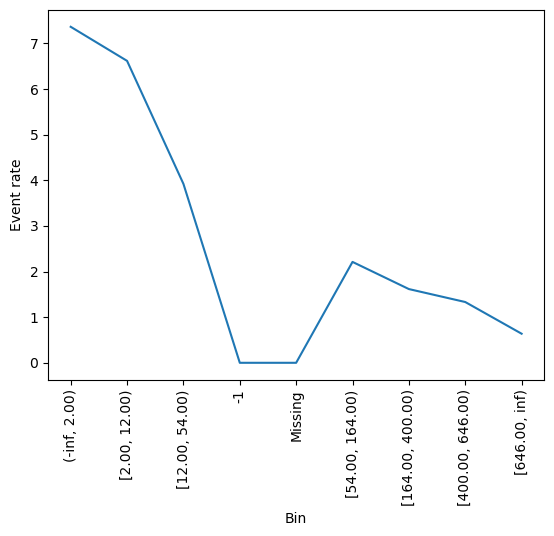

In [856]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[2, 12., 54.,  164., 400., 646.], 
    user_splits_fixed=[True]*6,
    special_codes=dict(zip(
        [
           -1
        ], 
        [
          -1
        ]
    )
                      )
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))

t = build_woe_table(optb)
_ = sns.lineplot(x=t.Bin.astype(str), y=t['Event rate'] * 100)
_ = plt.xticks(rotation=90)
t

In [857]:
col_alias = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_alias], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
7,"[646.00, inf)",99,5397,ND_ECC_06,5496,0.018013,0.823519,0.087881
0,-1,4,205,ND_ECC_06,209,0.019139,0.761755,0.003342
5,"[400.00, 646.00)",153,6432,ND_ECC_06,6585,0.023235,0.563643,0.105294
3,"[164.00, 400.00)",354,12940,ND_ECC_06,13294,0.026629,0.423821,0.212571
6,"[54.00, 164.00)",436,12933,ND_ECC_06,13369,0.032613,0.214935,0.213771
2,"[12.00, 54.00)",617,12180,ND_ECC_06,12797,0.048214,-0.192279,0.204624
4,"[2.00, 12.00)",403,5703,ND_ECC_06,6106,0.066001,-0.525149,0.097635
1,"(-inf, 2.00)",443,4240,ND_ECC_06,4683,0.094597,-0.916211,0.074881


In [858]:
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_alias], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_alias[:-len('OptBin')]].sort_values('WoE', ascending=False)

,Bin,B,G,Feature,n,Event rate,WoE,Count (%)
7,"[646.00, inf)",52,1594,ND_ECC_06,1646,0.031592,1.096249,0.109755
5,"[400.00, 646.00)",95,1574,ND_ECC_06,1669,0.056920,0.480989,0.111289
3,"[164.00, 400.00)",189,2868,ND_ECC_06,3057,0.061825,0.393114,0.203841
6,"[54.00, 164.00)",248,2811,ND_ECC_06,3059,0.081072,0.101357,0.203974
0,-1,4,45,ND_ECC_06,49,0.081633,0.093859,0.003267
2,"[12.00, 54.00)",356,2798,ND_ECC_06,3154,0.112873,-0.264780,0.210309
4,"[2.00, 12.00)",206,1131,ND_ECC_06,1337,0.154076,-0.623528,0.089151
1,"(-inf, 2.00)",184,842,ND_ECC_06,1026,0.179337,-0.805665,0.068414


#### E4_Q_17

In [40]:
col_name='E4_Q_17'

Ok given the low volume of the in  the arrears categories and due to the unintuitive pattern (i.e. reversals) if you were to categorise the data in any other way I'd recommend the following groupings: 

1) On ER and Worst CAIS 0/U (i.e. bin 2 on its own),
2) Not on ER and worst CAIS 0/U (i.e. bin 6 on its own)
3) Both the T/N categories (i.e. bins 1 and 5 grouped together)
4) then bins 3,4,7 and 8 together.

This will give you 4 robust groups with adequate volumes in each category and an intuitive pattern 

In [41]:
# check the distribution of each bin and the corresponding WoEs
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes=dict(zip(range(1, 8), range(1, 8)))
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[8],478,0.034290,427,51,0.106695,-1.320045,0.114475,0.013353
1,1,54,0.003874,51,3,0.055556,-0.61179,0.001949,0.000240
2,2,8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182
3,3,79,0.005667,68,11,0.139241,-1.623391,0.033261,0.003754
4,4,2088,0.149785,1937,151,0.072318,-0.893387,0.184897,0.022373
5,5,189,0.013558,178,11,0.058201,-0.661115,0.008162,0.001002
6,6,2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427
7,7,22,0.001578,20,2,0.090909,-1.142418,0.003610,0.000428
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.673754,0.080758


In [42]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={2: 2, '(1, 5)': [1, 5], '(3, 4, 7, 8)': [3, 4, 7, 8]}
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe", metric_special='empirical')
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins", metric_special='empirical')
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[6],2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427
1,2,8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182
2,"(1, 5)",243,0.017432,229,14,0.057613,-0.650339,0.010100,0.001241
3,"(3, 4, 7, 8)",2667,0.191320,2452,215,0.080615,-1.010982,0.320816,0.038477
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.658317,0.079326


#### TRD_A_20

In [43]:
np.sort(df.TRD_A_20.unique())

array([-3, -2, -1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36], dtype=int64)

In [728]:
col_name='TRD_A_20'

In [729]:
#  change values >= 1 to '1+' category
# - train dataset
mask = (df_train[col_name] >= 1)
df_train[col_name+'OptBin'] = df_train[col_name].mask(mask, '1+').values
del mask

# - full dataset
mask = df[col_name] >= 1
df[col_name+'OptBin'] = df[col_name].mask(mask, '1+').values

In [730]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={'{-3, 0}': [-3, 0], -2:-2, -1:-1}, 
    split_digits=0,
    # user_splits=[3],
    # user_splits_fixed=[True]
)
optb.fit(df_train[col_name+'OptBin'] , df_train[TARGET_BIN_IisB].values)

# df[f'Bin{col_name}'] = optb.transform(df[col_name+'OptBin'].values, metric="bins", metric_special='empirical')
# df[col_name + 'OptBin'] = optb.transform(df[col_name+'OptBin'].values, metric="woe", metric_special='empirical')

# dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
# s_params = optb.get_params()
# dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[1+],465,0.033357,457,8,0.017204,0.600239,0.009164,0.001129
1,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412
2,-2,7457,0.534935,7079,378,0.050691,-0.51501,0.181803,0.022478
3,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.671757,0.079018


In [731]:
COLS_MAN_CORRECT[col_name] = [
    {'Bin': "['1+']", 'WoE': 0}
]
COLS_MAN_CORRECT

{'TRD_A_20': [{'Bin': "['1+']", 'WoE': 0}]}

In [48]:
# Correct WoE values: 
df.loc[df[f'Bin{col_name}'] == COLS_MAN_CORRECT[col_name][0]['Bin'], col_name + 'OptBin'] = COLS_MAN_CORRECT[col_name][0]['WoE']

In [49]:
df[[col_name, f'Bin{col_name}',  col_name + 'OptBin']]

,TRD_A_20,BinTRD_A_20,TRD_A_20OptBin
0,21,['1+'],0.000000
1,-2,-2,-0.515010
2,-2,-2,-0.515010
3,-3,"{-3, 0}",1.436451
4,-2,-2,-0.515010
...,...,...,...
110457,-2,-2,-0.515010
110458,-2,-2,-0.515010
110459,-2,-2,-0.515010
110460,-3,"{-3, 0}",1.436451


#### GEN11_SP_N_92

In [50]:
col_name='GEN11_SP_N_92'

##### GEN11_SP_N_92_ABOther

In [51]:
print('If any case with "A" and "B" at the same value: ', (df[col_name].str.contains('A') & df[col_name].str.contains('B')).any())

If any case with "A" and "B" at the same value:  False


If `GEN11_SP_N_92` contains 
- 'A' -> 'A' 
- 'B' -> 'B'
- 'T' -> 'T'
- no 'A', no 'B' -> 'Other' 

In [52]:
df_train[col_name + '_ABOther'] = 'Other'

df_train[col_name + '_ABOther'] = df_train[col_name + '_ABOther'].mask(df_train[col_name].str.contains('A'), 'A').values
df_train[col_name + '_ABOther'] = df_train[col_name + '_ABOther'].mask(df_train[col_name].str.contains('B'), 'B').values
df_train[col_name + '_ABOther'] = df_train[col_name + '_ABOther'].mask(df_train[col_name].str.contains('T'), 'T').values

In [53]:
df[col_name + '_ABOther'] = 'Other'


df[col_name + '_ABOther'] = df[col_name + '_ABOther'].mask(df[col_name].str.contains('A'), 'A').values
df[col_name + '_ABOther'] = df[col_name + '_ABOther'].mask(df[col_name].str.contains('B'), 'B').values
df[col_name + '_ABOther'] = df[col_name + '_ABOther'].mask(df[col_name].str.contains('T'), 'T').values

In [54]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={'T': 'T'}
)
optb.fit(df_train[col_name + '_ABOther'], df_train[TARGET_BIN_IisB].values)
df[col_name + '_ABOther' + 'OptBin'] = optb.transform(df[col_name + '_ABOther'].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name + '_ABOther'}'] = optb.transform(df[col_name + '_ABOther'].values, metric="bins", metric_special='empirical')

dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name + '_ABOther'}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name + '_ABOther'}-negatives-separately-I-excl.jblb'))
df_abother = optb.binning_table.build()

In [55]:
df_abother

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[B],8452,0.606313,8342,110,0.013015,0.883575,0.320114,0.038761
1,[Other],4364,0.313056,4126,238,0.054537,-0.59221,0.146145,0.018006
2,[A],1083,0.077690,1000,83,0.076639,-0.956089,0.113345,0.013652
3,T,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.579603,0.070419


In [56]:
df[df[col_name + '_ABOther'] == 'Other'][col_name].value_counts() * 100 / df.shape[0]

GEN11_SP_N_92
G    10.157339
P     9.679347
J     4.435009
F     4.249425
S     2.803679
I     2.117470
U     0.382937
M     0.138509
Name: count, dtype: float64

##### Select one of `_IsA`, `_IsB`, `_ABOther`

In [57]:
COLUMNS_DICT.update({'GEN11_SP_N_92_ABOther': 'Char'})

#### GEN11_SP_K_80

In [58]:
col_name='GEN11_SP_K_80'

##### GEN11_SP_K_80_JSOther

Sole Account: ['S', 'U', 'F', 'G', 'I', 'J',]

Joint Account: [1-6]

In [59]:
col_name: str = 'GEN11_SP_K_80'

In [60]:
SOLE_VALUES = [
    'S',
    'U',
    'F',
    'G',
    'I',
    'J',
]
SOLE_VALUES = '[' + ''.join(SOLE_VALUES) + ']+'
JOINT_VALUES = '[' + ''.join([str(elem) for elem in range(1, 7)]) + ']+'

In [61]:
# patterns to search for
print(JOINT_VALUES)
print(SOLE_VALUES)

[123456]+
[SUFGIJ]+


In [62]:
df_train[col_name + '_JSOther'] = df_train[col_name].copy()

df_train[col_name + '_JSOther'] = df_train[col_name + '_JSOther'].mask(df_train[col_name].str.contains(SOLE_VALUES) & ~df_train[col_name].str.contains(JOINT_VALUES), 'Sole').values
df_train[col_name + '_JSOther'] = df_train[col_name + '_JSOther'].mask(df_train[col_name].str.contains(JOINT_VALUES), '(Joint)OR(Sole&Joint)').values
df_train[col_name + '_JSOther'] = df_train[col_name + '_JSOther'].mask(df_train[col_name].str.contains('T'), 'T').values

df_train[col_name + '_JSOther'].value_counts(normalize=True)

GEN11_SP_K_80_JSOther
Sole                     0.545624
(Joint)OR(Sole&Joint)    0.283931
XX                       0.167504
T                        0.002941
Name: proportion, dtype: float64

In [63]:
df[col_name + '_JSOther'] = df[col_name].copy()

df[col_name + '_JSOther'] = df[col_name + '_JSOther'].mask(df[col_name].str.contains(SOLE_VALUES) & ~df[col_name].str.contains(JOINT_VALUES), 'Sole').values
df[col_name + '_JSOther'] = df[col_name + '_JSOther'].mask(df[col_name].str.contains(JOINT_VALUES), '(Joint)OR(Sole&Joint)').values
df[col_name + '_JSOther'] = df[col_name + '_JSOther'].mask(df[col_name].str.contains('T'), 'T').values

df[col_name + '_JSOther'].value_counts(normalize=True)

GEN11_SP_K_80_JSOther
Sole                     0.562510
(Joint)OR(Sole&Joint)    0.253544
XX                       0.180786
T                        0.003159
Name: proportion, dtype: float64

In [64]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={'{T}': 'T'}
)
optb.fit(df_train[col_name + '_JSOther'], df_train[TARGET_BIN_IisB].values)
df[col_name + '_JSOther' + 'OptBin'] = optb.transform(df[col_name + '_JSOther'].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name + '_JSOther'}'] = optb.transform(df[col_name + '_JSOther'].values, metric="bins", metric_special='empirical')

dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name + '_JSOther'}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name + '_JSOther'}-negatives-separately-I-excl.jblb'))
df_JSOther = optb.binning_table.build()

In [65]:
df_JSOther

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[(Joint)OR(Sole&Joint)],3958,0.283931,3895,63,0.015917,0.679311,0.096567,0.011844
1,[XX],2335,0.167504,2256,79,0.033833,-0.093103,0.001517,0.000190
2,[Sole],7606,0.545624,7317,289,0.037996,-0.213474,0.027516,0.003433
3,{T},41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.125600,0.015467


In [66]:
COLUMNS_DICT.update(
    {
        col_name + '_JSOther': 'Char'
    }
)

##### GEN11_SP_K_80_TO

In [67]:
col_name

'GEN11_SP_K_80'

In [68]:
df_train[col_name + '_TO'] = df_train[col_name].copy()
for values in ([1, 2, 3, 4], [5, 6]):
    v_comb=''.join([str(v) for v in values])
    df_train[col_name + '_TO'] = df_train[col_name + '_TO'].mask(df_train[col_name].str.contains(r'[{}]+'.format(v_comb)), v_comb).values

df_train[col_name + '_TO'].value_counts(normalize=True)

GEN11_SP_K_80_TO
G       0.235940
1234    0.230846
XX      0.167504
J       0.106026
F       0.087877
S       0.061908
56      0.053085
I       0.039527
U       0.014347
T       0.002941
Name: proportion, dtype: float64

In [69]:
df[col_name + '_TO'] = df[col_name].copy()
for values in ([1, 2, 3, 4], [5, 6]):
    v_comb=''.join([str(v) for v in values])
    df[col_name + '_TO'] = df[col_name + '_TO'].mask(df[col_name].str.contains(r'[{}]+'.format(v_comb)), v_comb).values

df[col_name + '_TO'].value_counts(normalize=True)

GEN11_SP_K_80_TO
G       0.254540
1234    0.211829
XX      0.180786
F       0.096359
J       0.090918
S       0.061831
56      0.041716
I       0.036040
U       0.022822
T       0.003159
Name: proportion, dtype: float64

In [70]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={'XX': 'XX', 'T': 'T', '[J, I, S, U, G, F]': ['J', 'I', 'S', 'U', 'G', 'F']}
)
optb.fit(df_train[col_name + '_TO'], df_train[TARGET_BIN_IisB].values)
df[col_name + '_TO' + 'OptBin'] = optb.transform(df[col_name + '_TO'].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name + '_TO'}'] = optb.transform(df[col_name + '_TO'].values, metric="bins", metric_special='empirical')

dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name + '_TO'}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name + '_TO'}-negatives-separately-I-excl.jblb'))
df_TO = optb.binning_table.build()
df_TO

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[1234],3218,0.230846,3172,46,0.014295,0.788473,0.100986,0.012306
1,[56],740,0.053085,723,17,0.022973,0.305193,0.004296,0.000535
2,XX,2335,0.167504,2256,79,0.033833,-0.093103,0.001517,0.000190
3,T,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,"[J, I, S, U, G, F]",7606,0.545624,7317,289,0.037996,-0.213474,0.027516,0.003433
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.134315,0.016464


In [71]:
COLUMNS_DICT.update(
    {
        col_name + '_TO': 'Char'
    }
)

###### PR

In [72]:
df_train[col_name + '_PR'] = df_train[col_name].copy()
for values in ([1, 3, 5], [2, 4, 6]):
    v_comb=''.join([str(v) for v in values])
    df_train[col_name + '_PR'] = df_train[col_name + '_PR'].mask(df_train[col_name].str.contains(r'[{}]+'.format(v_comb)), v_comb).values

df_train[col_name + '_PR'].value_counts(normalize=True)

GEN11_SP_K_80_PR
G      0.235940
XX     0.167504
246    0.153085
135    0.130846
J      0.106026
F      0.087877
S      0.061908
I      0.039527
U      0.014347
T      0.002941
Name: proportion, dtype: float64

In [73]:
df[col_name + '_PR'] = df[col_name].copy()
for values in ([1, 3, 5], [2, 4, 6]):
    v_comb=''.join([str(v) for v in values])
    df[col_name + '_PR'] = df[col_name + '_PR'].mask(df[col_name].str.contains(r'[{}]+'.format(v_comb)), v_comb).values

df[col_name + '_PR'].value_counts(normalize=True)

GEN11_SP_K_80_PR
G      0.254540
XX     0.180786
246    0.137912
135    0.115633
F      0.096359
J      0.090918
S      0.061831
I      0.036040
U      0.022822
T      0.003159
Name: proportion, dtype: float64

In [74]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={'XX': 'XX', 'T': 'T', '[J, I, S, U, G, F]': ['J', 'I', 'S', 'U', 'G', 'F']}
)
optb.fit(df_train[col_name + '_PR'], df_train[TARGET_BIN_IisB].values)
df[col_name + '_PR' + 'OptBin'] = optb.transform(df[col_name + '_PR'].values, metric="woe", metric_special='empirical')
df[f'Bin{col_name + '_PR'}'] = optb.transform(df[col_name + '_PR'].values, metric="bins", metric_special='empirical')

dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name + '_PR'}-negatives-separately-I-excl.jblb'))
s_params = optb.get_params()
dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name + '_PR'}-negatives-separately-I-excl.jblb'))
df_PR = optb.binning_table.build()
df_PR

C:\Users\hdychko\AppData\Local\Temp\ipykernel_648\3662899118.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name + '_PR' + 'OptBin'] = optb.transform(df[col_name + '_PR'].values, metric="woe", metric_special='empirical')
C:\Users\hdychko\AppData\Local\Temp\ipykernel_648\3662899118.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Bin{col_name + '_PR'}'] = optb.transform(df[col_name + '_PR'].values, metric="bins", metric_special='empirical')


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[135],1824,0.130846,1798,26,0.014254,0.79133,0.057586,0.007016
1,[246],2134,0.153085,2097,37,0.017338,0.592342,0.041098,0.005063
2,XX,2335,0.167504,2256,79,0.033833,-0.093103,0.001517,0.000190
3,T,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,"[J, I, S, U, G, F]",7606,0.545624,7317,289,0.037996,-0.213474,0.027516,0.003433
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.127718,0.015702


In [75]:
COLUMNS_DICT.update(
    {
        col_name + '_PR': 'Char'
    }
)

### Separate specific neg. values, other negative - as part of numeric, edges as ints

<Axes: ylabel='Frequency'>

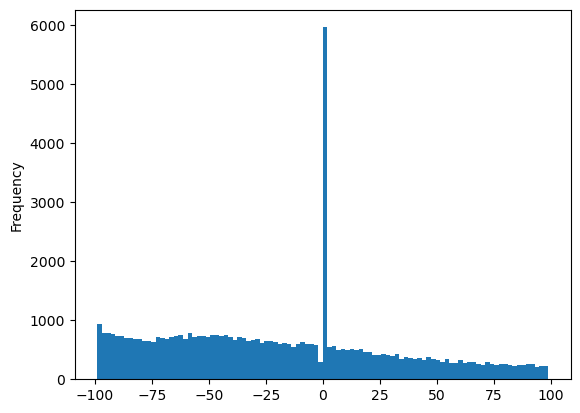

In [1540]:
df[(df.TRD_B_08 > -100) & (df.TRD_B_08 < 100)].TRD_B_08.plot.hist(bins=100)

<Axes: ylabel='Frequency'>

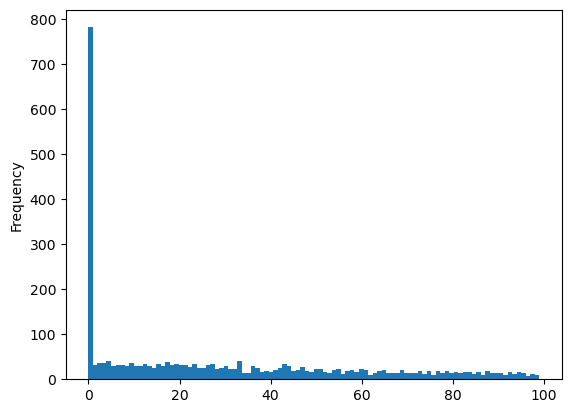

In [1534]:
df_train[(df_train.TRD_B_08 >= 0) & (df_train.TRD_B_08 < 100)].TRD_B_08.plot.hist(bins=100)

In [1535]:
(df_train.TRD_B_08 == 0).sum()

782

In [1537]:
COLUMNS_SP_SPLITS: Dict[str, Any] = {
    # 'TRD_B_20': {
    #     'special_codes': dict(
    #         zip(
    #             [
    #                 -999999,
    #                 -999998,
    #                 -999997,
    #                 -999996,
    #                 0
    #             ], 
    #             [
    #                 -999999,
    #                 -999998,
    #                 -999997,
    #                 -999996,
    #                 0
    #             ]
    #         )
    #     ),
    #     'user_splits': [0],
    #     'user_splits_fixed': [True]
    # },
    # 'SP_B2_18': { # checked
    #     'special_codes': dict(
    #         zip(
    #             [
    #                 9997,
    #                 9998,
    #                 9999,
    #                 -1
    #             ], 
    #             [
    #                 9997,
    #                 9998,
    #                 9999,
    #                 -1
    #             ]
    #         )
    #     ), 
    #     'user_splits': [90],
    #     'user_splits_fixed': [True]
    # },
    # 'TRD_B_18': {
    #     'special_codes': dict(
    #         zip(
    #             [
    #                 -999999,
    #                 -999998,
    #                 -999997,
    #                 -999996, 
    #                 0
                    
    #             ], 
    #             [
    #                 -999999,
    #                 -999998,
    #                 -999997,
    #                 -999996, 
    #                 0
    #             ]
    #         )
    #     ),
    #     'user_splits': [0],
    #     'user_splits_fixed': [True]
    # },
    'TRD_B_08': {
        'special_codes': 
            dict(
                zip(
                    [
                        -999999,
                        -999998,
                        -999997,
                        -999996,
                        0
                    ],
                    [
                        -999999,
                        -999998,
                        -999997,
                        -999996,
                        0
                    ]
                )
        ),
    'user_splits': [0],
    'user_splits_fixed': [True]
    }, 

    # 'ND_ECC_04': {
    #     'special_codes': dict(
    #         zip(
    #             [
    #                 -1,
    #                 998,
    #                 999,
    #             ],
    #             [
    #                 -1,
    #                 998,
    #                 999,
    #             ]
    #         )
    #     ),
    # 'user_splits': [5],
    # 'user_splits_fixed': [True] 
    # }, 
    # 'SP_B2_20': {
    #      'special_codes': dict(
    #         zip(
    #             [
    #                 -1,
    #                 9997,
    #                 9998,
    #                 9999,
    #             ],
    #             [
    #                 -1,
    #                 9997,
    #                 9998,
    #                 9999,
    #             ]
    #         )
    #     ),
    #     'user_splits': [38, 94],
    #     'user_splits_fixed': [True, True] 
    # }, 
}

In [1538]:
exceptions = []
for col_name in tqdm(COLUMNS_SP_SPLITS.keys()):
    try: 
        unique_vals = df[col_name].unique()
        
        dict_to_replace: Dict[str, float] = dict()
        unique_floats: List[float] = []
        for elem in unique_vals:
            try:
                dict_to_replace[elem] = float(elem)
                unique_floats += [float(elem)]
            except ValueError:
                pass


        optb = OptimalBinning(
            # min_prebin_size=0.5,
            name=col_name, 
            dtype='numerical', 
            solver="mip",
            special_codes=COLUMNS_SP_SPLITS[col_name]['special_codes'],
            monotonic_trend='auto_asc_desc',
            user_splits=COLUMNS_SP_SPLITS[col_name].get('user_splits'),
            user_splits_fixed=COLUMNS_SP_SPLITS[col_name].get('user_splits_fixed'), 
            min_n_bins=len(COLUMNS_SP_SPLITS[col_name]['special_codes']) + \
                sum(COLUMNS_SP_SPLITS[col_name].get('user_splits_fixed') if COLUMNS_SP_SPLITS[col_name].get('user_splits_fixed') is not None else [0]),
            split_digits=0
        )
        optb.fit(df_train[col_name].replace(dict_to_replace).values, df_train[TARGET_BIN_IisB].values)
        df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe", metric_special='empirical')
        df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="bins", metric_special='empirical')
        dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
        s_params = optb.get_params()
        # print(s_params)
        dump(s_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
        temp = optb.binning_table.build()
        print(f'IV: ', temp.loc['Totals',  'IV'])
        print(temp)
    except Exception as e:
            exceptions += [(col_name, e)]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]

IV:  0.32176463582820436
                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.00)   5201   0.373099       5109     92    0.017689   
1        [0.00, inf)   5601   0.401793       5460    141    0.025174   
2            -999999     41   0.002941         41      0    0.000000   
3            -999998    568   0.040746        512     56    0.098592   
4            -999997     18   0.001291         18      0    0.000000   
5            -999996   1729   0.124032       1628    101    0.058415   
6                  0    782   0.056098        741     41    0.052430   
7            Missing      0   0.000000          0      0    0.000000   
Totals                13940   1.000000      13509    431    0.030918   

             WoE        IV        JS  
0       0.571967  0.094223  0.011620  
1       0.211441  0.016287  0.002032  
2            0.0  0.000000  0.000000  
3       -1.23203  0.113383  0.013339  
4            0.0  0.000000  0.000000  
5      -0.665016  0.

In [1539]:
temp

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",5201,0.373099,5109,92,0.017689,0.571967,0.094223,0.011620
1,"[0.00, inf)",5601,0.401793,5460,141,0.025174,0.211441,0.016287,0.002032
2,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
3,-999998,568,0.040746,512,56,0.098592,-1.23203,0.113383,0.013339
4,-999997,18,0.001291,18,0,0.000000,0.0,0.000000,0.000000
5,-999996,1729,0.124032,1628,101,0.058415,-0.665016,0.075696,0.009291
6,0,782,0.056098,741,41,0.052430,-0.550575,0.022175,0.002737
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.321765,0.039020


In [1532]:
if len(exceptions) > 0:
    print('If any Exception: ', len(exceptions))
    for elem in exceptions:
        print(elem)


In [1541]:
temp = temp[
    [
        'Bin', 'Count (%)', 'Event rate', 'WoE'
    ]
].loc[~temp.Bin.isin(['Missing', '']), :]
temp.Bin = temp.Bin.astype(str)

# train 
col_name = f'{col_name}OptBin'

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_train_bin_sts = recompute_woe(data=df_train_val, cols=[col_name], target_name=TARGET_NAME)
df_train_bin_sts[df_train_bin_sts.Feature == col_name[:-len('OptBin')]]
df_train_bin_sts.Bin = df_train_bin_sts.Bin.astype(str)
df_train_bin_sts['Event rate'] *= 100

# test 
df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_bin_sts = recompute_woe(data=df_test_same, cols=[col_name], target_name=TARGET_NAME)
df_test_bin_sts[df_test_bin_sts.Feature == col_name[:-len('OptBin')]]
df_test_bin_sts.Bin = df_test_bin_sts.Bin.astype(str)
df_test_bin_sts['Event rate'] *= 100

# all together
temp = pd.merge(temp, df_train_bin_sts[['Bin', 'Event rate', 'Count (%)', 'WoE']].set_index('Bin').loc[temp.Bin, :].reset_index(), on='Bin', suffixes=('_binning', '_train'))
temp = pd.merge(temp, df_test_bin_sts[['Bin', 'Event rate', 'Count (%)', 'WoE']].set_index('Bin').loc[temp.Bin, :].reset_index(), on='Bin', suffixes=('', '_test'))
temp

,Bin,Count (%)_binning,Event rate_binning,WoE_binning,Event rate_train,Count (%)_train,WoE_train,Event rate,Count (%),WoE
0,"(-inf, 0.00)",0.373099,0.017689,0.571967,2.629849,0.364812,0.436633,6.015038,0.310395,0.422363
1,"[0.00, inf)",0.401793,0.025174,0.211441,3.501195,0.414685,0.141466,7.255335,0.453091,0.221604
2,-999999,0.002941,0.000000,0.0,1.913876,0.003342,0.761755,8.163265,0.003267,0.093859
3,-999998,0.040746,0.098592,-1.23203,9.336890,0.041958,-0.901783,19.804742,0.047810,-0.927967
4,-999997,0.001291,0.000000,0.0,9.589041,0.001167,-0.931216,41.666667,0.000800,-1.990037
5,-999996,0.124032,0.058415,-0.665016,6.299830,0.122340,-0.475383,14.172448,0.134560,-0.525469
6,0,0.056098,0.052430,-0.550575,8.134859,0.051696,-0.750797,16.511318,0.050077,-0.705845


## WoE per bin

In [70]:
[col for col in df.columns if 'GEN11_SP_N_92' in col]

['GEN11_SP_N_92',
 'GEN11_SP_N_92_ABOther',
 'GEN11_SP_N_92_ABOtherOptBin',
 'BinGEN11_SP_N_92_ABOther']

In [71]:
[col for col in df.columns if 'GEN11_SP_K_80' in col]

['GEN11_SP_K_80',
 'GEN11_SP_K_80_JSOther',
 'GEN11_SP_K_80_JSOtherOptBin',
 'BinGEN11_SP_K_80_JSOther',
 'GEN11_SP_K_80_TO',
 'GEN11_SP_K_80_TOOptBin',
 'BinGEN11_SP_K_80_TO',
 'GEN11_SP_K_80_PR',
 'GEN11_SP_K_80_PROptBin',
 'BinGEN11_SP_K_80_PR']

In [72]:
COLS_INTER = [
    'EA5_S_01',
    'E4_Q_17',
    'TRD_A_20',
    'SP_B2_20',
    'TRD_B_24',
    'TRD_B_20',
    'SP_B2_18',
    'TRD_B_18',
    'TRD_B_08',
    'ND_ECC_04', 
    'GEN11_SP_N_92_ABOther',
    'GEN11_SP_K_80_JSOther',
    'GEN11_SP_K_80_PR',
    'GEN11_SP_K_80_TO'
]

In [73]:
def find_max_of_negative_bins(x):
    v: Union[float, np.nan] = np.nan
    try: 
        v = float(x)
        return v
    except:
        return np.nan

In [74]:
#  extract intervals
warnings.filterwarnings("ignore", category=FutureWarning)
df_intervals = pd.DataFrame()
for col_name in COLUMNS_DICT.keys():
    optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
    temp = optb.binning_table.build(add_totals=False)
    temp['Feature'] = col_name
    temp.Bin = temp.Bin.astype(str)
    temp = temp[~((temp.Bin == 'Missing') & (temp.Count == 0))]
    temp = temp[~((temp.Bin == 'Special') & (temp.Count == 0))]
    temp = temp[(temp.Bin != 'OptBin')]
    temp = temp.reset_index(drop=True)
    df_intervals = pd.concat((df_intervals, temp))

In [75]:
df_intervals.head()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature
0,"(-inf, 684.50)",1327,0.095194,1145,182,0.137151,-1.605850,0.541999,0.061296,OPTIN_11SCN_ML
1,"[684.50, 760.50)",1100,0.078910,1001,99,0.090000,-1.131368,0.176040,0.020902,OPTIN_11SCN_ML
2,"[760.50, 814.50)",845,0.060617,796,49,0.057988,-0.657224,0.035993,0.004420,OPTIN_11SCN_ML
3,"[814.50, 859.50)",699,0.050143,676,23,0.032904,-0.064304,0.000214,0.000027,OPTIN_11SCN_ML
4,"[859.50, 955.50)",1661,0.119154,1627,34,0.020470,0.423129,0.017582,0.002181,OPTIN_11SCN_ML


In [76]:
df_intervals_st = df_intervals[~df_intervals.Feature.isin(COLS_INTER)].reset_index(drop=True).copy()
df_intervals_mod = df_intervals[df_intervals.Feature.isin(COLS_INTER)].reset_index(drop=True).copy()

In [77]:
temp = df_intervals_st.groupby('Feature').apply(lambda y: y.Bin.apply(lambda x: float(find_max_of_negative_bins(x))).astype(float).max()).reset_index(name='min_val')
df_intervals_st = pd.merge(df_intervals_st, temp, on='Feature', how='left')
df_intervals_st['Bin'] = df_intervals_st.apply(lambda x: x.Bin.replace('(-inf', '(' + str(x.min_val)) if not np.isnan(x.min_val) else x.Bin, axis=1)
del df_intervals_st['min_val']
df_intervals_st

C:\Users\hdychko\AppData\Local\Temp\ipykernel_26528\4025125238.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = df_intervals_st.groupby('Feature').apply(lambda y: y.Bin.apply(lambda x: float(find_max_of_negative_bins(x))).astype(float).max()).reset_index(name='min_val')


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature
0,"(-997.0, 684.50)",1327,0.095194,1145,182,0.137151,-1.605850,0.541999,0.061296,OPTIN_11SCN_ML
1,"[684.50, 760.50)",1100,0.078910,1001,99,0.090000,-1.131368,0.176040,0.020902,OPTIN_11SCN_ML
2,"[760.50, 814.50)",845,0.060617,796,49,0.057988,-0.657224,0.035993,0.004420,OPTIN_11SCN_ML
3,"[814.50, 859.50)",699,0.050143,676,23,0.032904,-0.064304,0.000214,0.000027,OPTIN_11SCN_ML
4,"[859.50, 955.50)",1661,0.119154,1627,34,0.020470,0.423129,0.017582,0.002181,OPTIN_11SCN_ML
...,...,...,...,...,...,...,...,...,...,...
233,"(-1.0, 2.00)",8433,0.604950,8178,255,0.030238,0.022936,0.000315,0.000039,VM01_SP_VM2_24
234,"[2.00, 4.00)",2355,0.168938,2328,27,0.011465,1.011925,0.110992,0.013311,VM01_SP_VM2_24
235,"[4.00, inf)",1405,0.100789,1396,9,0.006406,1.599138,0.131860,0.014924,VM01_SP_VM2_24
236,-2.0,1706,0.122382,1566,140,0.082063,-1.030366,0.215247,0.025775,VM01_SP_VM2_24


In [78]:
df_intervals_mod['Bin_init'] = df_intervals_mod['Bin'].copy()

#### E4_Q_17

In [79]:
df_intervals_mod[df_intervals_mod.Feature == 'E4_Q_17']

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
4,[6],2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427,E4_Q_17,[6]
5,2,8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182,E4_Q_17,2
6,"(1, 5)",243,0.017432,229,14,0.057613,-0.650339,0.010100,0.001241,E4_Q_17,"(1, 5)"
7,"(3, 4, 7, 8)",2667,0.191320,2452,215,0.080615,-1.010982,0.320816,0.038477,E4_Q_17,"(3, 4, 7, 8)"


In [80]:
DICT_REPLC = {
    '[6]': '{6}',
    '(1, 5)': '{1, 5}',
    '(3, 4, 7, 8)': '{3, 4, 7, 8}',
    '2': '{2}'
}

In [81]:
df_intervals_mod.loc[df_intervals_mod.Feature == 'E4_Q_17', 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == 'E4_Q_17'].Bin.replace(
   DICT_REPLC
).values

In [82]:
df_intervals_mod[df_intervals_mod.Feature == 'E4_Q_17']

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
4,{6},2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427,E4_Q_17,[6]
5,{2},8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182,E4_Q_17,2
6,"{1, 5}",243,0.017432,229,14,0.057613,-0.650339,0.010100,0.001241,E4_Q_17,"(1, 5)"
7,"{3, 4, 7, 8}",2667,0.191320,2452,215,0.080615,-1.010982,0.320816,0.038477,E4_Q_17,"(3, 4, 7, 8)"


In [83]:
df['BinE4_Q_17'] = df['BinE4_Q_17'].replace(DICT_REPLC)

#### TRD_A_20

In [84]:
col_name = 'TRD_A_20'

In [85]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
0,['1+'],465,0.033357,457,8,0.017204,0.600239,0.009164,0.001129,TRD_A_20,['1+']
1,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412,TRD_A_20,"{-3, 0}"
2,-2,7457,0.534935,7079,378,0.050691,-0.515010,0.181803,0.022478,TRD_A_20,-2
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_A_20,-1


In [86]:
df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.values

array(["['1+']", '{-3, 0}', '-2', '-1'], dtype=object)

In [87]:
DICT_REPLC =  {
    "['1+']": '[1, inf)',
}

In [88]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.replace(
    DICT_REPLC
).values

In [89]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
0,"[1, inf)",465,0.033357,457,8,0.017204,0.600239,0.009164,0.001129,TRD_A_20,['1+']
1,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412,TRD_A_20,"{-3, 0}"
2,-2,7457,0.534935,7079,378,0.050691,-0.515010,0.181803,0.022478,TRD_A_20,-2
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_A_20,-1


In [90]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)

In [91]:
COLS_MAN_CORRECT

{'TRD_A_20': [{'Bin': "['1+']", 'WoE': 0}]}

In [92]:
# change woe
df_intervals_mod.loc[(df_intervals_mod.Feature == col_name) & (df_intervals_mod.Bin == '[1, inf)'), 'WoE'] = 0

In [93]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
0,"[1, inf)",465,0.033357,457,8,0.017204,0.000000,0.009164,0.001129,TRD_A_20,['1+']
1,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412,TRD_A_20,"{-3, 0}"
2,-2,7457,0.534935,7079,378,0.050691,-0.515010,0.181803,0.022478,TRD_A_20,-2
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_A_20,-1


#### SP_B2_20


In [94]:
df[df.SP_B2_20 < 0].SP_B2_20.unique()

array([-1], dtype=int64)

In [95]:
col_name = 'SP_B2_20'

In [96]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
48,"(-inf, 38.00)",1066,0.076471,1050,16,0.015009,0.738953,0.030004,0.003667,SP_B2_20,"(-inf, 38.00)"
49,"[38.00, 94.00)",5829,0.418149,5726,103,0.017670,0.573040,0.105947,0.013065,SP_B2_20,"[38.00, 94.00)"
50,"[94.00, inf)",2411,0.172956,2353,58,0.024056,0.258000,0.010219,0.001274,SP_B2_20,"[94.00, inf)"
51,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,SP_B2_20,-1
52,9997,78,0.005595,67,11,0.141026,-1.638206,0.033685,0.003795,SP_B2_20,9997
53,9998,4487,0.321879,4245,242,0.053934,-0.580444,0.143515,0.017692,SP_B2_20,9998
54,9999,28,0.002009,27,1,0.035714,-0.149166,0.000048,0.000006,SP_B2_20,9999


In [97]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[0')

In [98]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('inf)', '9996]')

In [99]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
48,"[0, 38.00)",1066,0.076471,1050,16,0.015009,0.738953,0.030004,0.003667,SP_B2_20,"(-inf, 38.00)"
49,"[38.00, 94.00)",5829,0.418149,5726,103,0.017670,0.573040,0.105947,0.013065,SP_B2_20,"[38.00, 94.00)"
50,"[94.00, 9996]",2411,0.172956,2353,58,0.024056,0.258000,0.010219,0.001274,SP_B2_20,"[94.00, inf)"
51,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,SP_B2_20,-1
52,9997,78,0.005595,67,11,0.141026,-1.638206,0.033685,0.003795,SP_B2_20,9997
53,9998,4487,0.321879,4245,242,0.053934,-0.580444,0.143515,0.017692,SP_B2_20,9998
54,9999,28,0.002009,27,1,0.035714,-0.149166,0.000048,0.000006,SP_B2_20,9999


In [100]:
DICT_REPLC = df_intervals_mod[df_intervals_mod.Feature == col_name][['Bin', 'Bin_init']].set_index('Bin_init')['Bin'].to_dict()
DICT_REPLC

{'(-inf, 38.00)': '[0, 38.00)',
 '[38.00, 94.00)': '[38.00, 94.00)',
 '[94.00, inf)': '[94.00, 9996]',
 '-1': '-1',
 '9997': '9997',
 '9998': '9998',
 '9999': '9999'}

In [101]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)

#### TRD_B_20

In [102]:
col_name = 'TRD_B_20'

In [103]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
8,"(-inf, 0.00)",3656,0.262267,3612,44,0.012035,0.962824,0.159144,0.019159,TRD_B_20,"(-inf, 0.00)"
9,"[0.00, 450.00)",4406,0.316069,4340,66,0.014980,0.740972,0.124583,0.015226,TRD_B_20,"[0.00, 450.00)"
10,"[450.00, 800.00)",358,0.025681,352,6,0.016760,0.626868,0.007607,0.000936,TRD_B_20,"[450.00, 800.00)"
11,"[800.00, inf)",793,0.056887,767,26,0.032787,-0.060613,0.000215,0.000027,TRD_B_20,"[800.00, inf)"
12,-999999,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_B_20,-999999
13,-999998,1904,0.136585,1747,157,0.082458,-1.035594,0.243311,0.029124,TRD_B_20,-999998
14,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_20,-999997
15,-999996,1536,0.110187,1474,62,0.040365,-0.276403,0.009602,0.001196,TRD_B_20,-999996
16,-100,848,0.060832,838,10,0.011792,0.983430,0.038187,0.004590,TRD_B_20,-100


In [104]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '(-100')

In [105]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
8,"(-100, 0.00)",3656,0.262267,3612,44,0.012035,0.962824,0.159144,0.019159,TRD_B_20,"(-inf, 0.00)"
9,"[0.00, 450.00)",4406,0.316069,4340,66,0.014980,0.740972,0.124583,0.015226,TRD_B_20,"[0.00, 450.00)"
10,"[450.00, 800.00)",358,0.025681,352,6,0.016760,0.626868,0.007607,0.000936,TRD_B_20,"[450.00, 800.00)"
11,"[800.00, inf)",793,0.056887,767,26,0.032787,-0.060613,0.000215,0.000027,TRD_B_20,"[800.00, inf)"
12,-999999,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_B_20,-999999
13,-999998,1904,0.136585,1747,157,0.082458,-1.035594,0.243311,0.029124,TRD_B_20,-999998
14,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_20,-999997
15,-999996,1536,0.110187,1474,62,0.040365,-0.276403,0.009602,0.001196,TRD_B_20,-999996
16,-100,848,0.060832,838,10,0.011792,0.983430,0.038187,0.004590,TRD_B_20,-100


In [106]:
DICT_REPLC = df_intervals_mod[df_intervals_mod.Feature == col_name][['Bin', 'Bin_init']].set_index('Bin_init')['Bin'].to_dict()
DICT_REPLC

{'(-inf, 0.00)': '(-100, 0.00)',
 '[0.00, 450.00)': '[0.00, 450.00)',
 '[450.00, 800.00)': '[450.00, 800.00)',
 '[800.00, inf)': '[800.00, inf)',
 '-999999': '-999999',
 '-999998': '-999998',
 '-999997': '-999997',
 '-999996': '-999996',
 '-100': '-100'}

In [107]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)

In [108]:
df[f'Bin{col_name}'].value_counts()

BinTRD_B_20
[0.00, 450.00)      35473
(-100, 0.00)        25201
-999998             16287
-999996             13478
[800.00, inf)        7109
-100                 5893
-999997              3354
[450.00, 800.00)     3318
-999999               349
Name: count, dtype: int64

#### SP_B2_18

In [109]:
col_name = 'SP_B2_18'

In [110]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
17,"(-inf, 82.00)",3397,0.243687,3361,36,0.010598,1.091472,0.180388,0.021492,SP_B2_18,"(-inf, 82.00)"
18,"[82.00, 92.00)",1025,0.073529,1014,11,0.010732,1.078760,0.053441,0.006374,SP_B2_18,"[82.00, 92.00)"
19,"[92.00, 156.00)",2436,0.174749,2397,39,0.016010,0.673408,0.058553,0.007184,SP_B2_18,"[92.00, 156.00)"
20,"[156.00, inf)",698,0.050072,684,14,0.020057,0.443897,0.008057,0.000999,SP_B2_18,"[156.00, inf)"
21,9997,576,0.041320,520,56,0.097222,-1.216526,0.111236,0.013106,SP_B2_18,9997
22,9998,5066,0.363415,4880,186,0.036715,-0.177849,0.012505,0.001561,SP_B2_18,9998
23,9999,701,0.050287,612,89,0.126961,-1.516907,0.244515,0.027935,SP_B2_18,9999
24,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,SP_B2_18,-1


In [111]:
df[df.SP_B2_18 < 0].SP_B2_18.unique()

array([-1], dtype=int64)

In [112]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[0')

In [113]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('inf)', '9996]')

In [114]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
17,"[0, 82.00)",3397,0.243687,3361,36,0.010598,1.091472,0.180388,0.021492,SP_B2_18,"(-inf, 82.00)"
18,"[82.00, 92.00)",1025,0.073529,1014,11,0.010732,1.078760,0.053441,0.006374,SP_B2_18,"[82.00, 92.00)"
19,"[92.00, 156.00)",2436,0.174749,2397,39,0.016010,0.673408,0.058553,0.007184,SP_B2_18,"[92.00, 156.00)"
20,"[156.00, 9996]",698,0.050072,684,14,0.020057,0.443897,0.008057,0.000999,SP_B2_18,"[156.00, inf)"
21,9997,576,0.041320,520,56,0.097222,-1.216526,0.111236,0.013106,SP_B2_18,9997
22,9998,5066,0.363415,4880,186,0.036715,-0.177849,0.012505,0.001561,SP_B2_18,9998
23,9999,701,0.050287,612,89,0.126961,-1.516907,0.244515,0.027935,SP_B2_18,9999
24,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,SP_B2_18,-1


In [115]:
DICT_REPLC = df_intervals_mod[df_intervals_mod.Feature == col_name][['Bin', 'Bin_init']].set_index('Bin_init')['Bin'].to_dict()
DICT_REPLC

{'(-inf, 82.00)': '[0, 82.00)',
 '[82.00, 92.00)': '[82.00, 92.00)',
 '[92.00, 156.00)': '[92.00, 156.00)',
 '[156.00, inf)': '[156.00, 9996]',
 '9997': '9997',
 '9998': '9998',
 '9999': '9999',
 '-1': '-1'}

In [116]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)

In [117]:
df[f'Bin{col_name}'].value_counts()

BinSP_B2_18
9998               42772
[0, 82.00)         21584
[92.00, 156.00)    20992
[156.00, 9996]      7577
[82.00, 92.00)      6644
9999                5480
9997                5064
-1                   349
Name: count, dtype: int64

#### TRD_B_18

In [118]:
col_name = 'TRD_B_18'

In [119]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
25,"(-inf, 0.00)",5431,0.389598,5355,76,0.013994,0.810049,0.178266,0.021693,TRD_B_18,"(-inf, 0.00)"
26,"[0.00, 100.00)",4306,0.308895,4188,118,0.027404,0.124291,0.004504,0.000563,TRD_B_18,"[0.00, 100.00)"
27,"[100.00, inf)",1899,0.136227,1859,40,0.021064,0.393911,0.017649,0.002192,TRD_B_18,"[100.00, inf)"
28,-999999,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_B_18,-999999
29,-999998,856,0.061406,774,82,0.095794,-1.200151,0.159572,0.018829,TRD_B_18,-999998
30,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_18,-999997
31,-999996,1009,0.072382,954,55,0.054509,-0.591673,0.033720,0.004155,TRD_B_18,-999996


In [120]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[-100')

In [121]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
25,"[-100, 0.00)",5431,0.389598,5355,76,0.013994,0.810049,0.178266,0.021693,TRD_B_18,"(-inf, 0.00)"
26,"[0.00, 100.00)",4306,0.308895,4188,118,0.027404,0.124291,0.004504,0.000563,TRD_B_18,"[0.00, 100.00)"
27,"[100.00, inf)",1899,0.136227,1859,40,0.021064,0.393911,0.017649,0.002192,TRD_B_18,"[100.00, inf)"
28,-999999,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_B_18,-999999
29,-999998,856,0.061406,774,82,0.095794,-1.200151,0.159572,0.018829,TRD_B_18,-999998
30,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_18,-999997
31,-999996,1009,0.072382,954,55,0.054509,-0.591673,0.033720,0.004155,TRD_B_18,-999996


In [122]:
DICT_REPLC = df_intervals_mod[df_intervals_mod.Feature == col_name][['Bin', 'Bin_init']].set_index('Bin_init')['Bin'].to_dict()
DICT_REPLC

{'(-inf, 0.00)': '[-100, 0.00)',
 '[0.00, 100.00)': '[0.00, 100.00)',
 '[100.00, inf)': '[100.00, inf)',
 '-999999': '-999999',
 '-999998': '-999998',
 '-999997': '-999997',
 '-999996': '-999996'}

In [123]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)

In [124]:
df[f'Bin{col_name}'].value_counts()

BinTRD_B_18
[0.00, 100.00)    36084
[-100, 0.00)      32951
[100.00, inf)     20460
-999996           10165
-999998            7099
-999997            3354
-999999             349
Name: count, dtype: int64

#### TRD_B_08

In [125]:
col_name = 'TRD_B_08'

In [126]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
32,"(-inf, 0.00)",5201,0.373099,5109,92,0.017689,0.571967,0.094223,0.011620,TRD_B_08,"(-inf, 0.00)"
33,"[0.00, 100.00)",2931,0.210258,2841,90,0.030706,0.007098,0.000011,0.000001,TRD_B_08,"[0.00, 100.00)"
34,"[100.00, inf)",3452,0.247633,3360,92,0.026651,0.152904,0.005392,0.000673,TRD_B_08,"[100.00, inf)"
35,-999999,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_B_08,-999999
36,-999998,568,0.040746,512,56,0.098592,-1.232030,0.113383,0.013339,TRD_B_08,-999998
37,-999997,18,0.001291,18,0,0.000000,0.000000,0.000000,0.000000,TRD_B_08,-999997
38,-999996,1729,0.124032,1628,101,0.058415,-0.665016,0.075696,0.009291,TRD_B_08,-999996


In [127]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[-100')

In [128]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
32,"[-100, 0.00)",5201,0.373099,5109,92,0.017689,0.571967,0.094223,0.011620,TRD_B_08,"(-inf, 0.00)"
33,"[0.00, 100.00)",2931,0.210258,2841,90,0.030706,0.007098,0.000011,0.000001,TRD_B_08,"[0.00, 100.00)"
34,"[100.00, inf)",3452,0.247633,3360,92,0.026651,0.152904,0.005392,0.000673,TRD_B_08,"[100.00, inf)"
35,-999999,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_B_08,-999999
36,-999998,568,0.040746,512,56,0.098592,-1.232030,0.113383,0.013339,TRD_B_08,-999998
37,-999997,18,0.001291,18,0,0.000000,0.000000,0.000000,0.000000,TRD_B_08,-999997
38,-999996,1729,0.124032,1628,101,0.058415,-0.665016,0.075696,0.009291,TRD_B_08,-999996


In [129]:
DICT_REPLC = df_intervals_mod[df_intervals_mod.Feature == col_name][['Bin', 'Bin_init']].set_index('Bin_init')['Bin'].to_dict()
DICT_REPLC

{'(-inf, 0.00)': '[-100, 0.00)',
 '[0.00, 100.00)': '[0.00, 100.00)',
 '[100.00, inf)': '[100.00, inf)',
 '-999999': '-999999',
 '-999998': '-999998',
 '-999997': '-999997',
 '-999996': '-999996'}

In [130]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)

In [131]:
df[f'Bin{col_name}'].value_counts()

BinTRD_B_08
[-100, 0.00)      38339
[100.00, inf)     29532
[0.00, 100.00)    22953
-999996           14252
-999998            4910
-999999             349
-999997             127
Name: count, dtype: int64

#### ND_ECC_04

In [132]:
col_name = 'ND_ECC_04'

In [133]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
55,"(-inf, 5.00)",822,0.058967,729,93,0.113139,-1.385929,0.224262,0.025985,ND_ECC_04,"(-inf, 5.00)"
56,"[5.00, inf)",532,0.038164,518,14,0.026316,0.165915,0.000973,0.000121,ND_ECC_04,"[5.00, inf)"
57,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,ND_ECC_04,-1
58,998,1202,0.086227,1131,71,0.059068,-0.676826,0.054830,0.006726,ND_ECC_04,998
59,999,11343,0.813702,11090,253,0.022305,0.335406,0.078461,0.009762,ND_ECC_04,999


In [134]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[0')

In [135]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('inf)', '997]')

In [136]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
55,"[0, 5.00)",822,0.058967,729,93,0.113139,-1.385929,0.224262,0.025985,ND_ECC_04,"(-inf, 5.00)"
56,"[5.00, 997]",532,0.038164,518,14,0.026316,0.165915,0.000973,0.000121,ND_ECC_04,"[5.00, inf)"
57,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,ND_ECC_04,-1
58,998,1202,0.086227,1131,71,0.059068,-0.676826,0.054830,0.006726,ND_ECC_04,998
59,999,11343,0.813702,11090,253,0.022305,0.335406,0.078461,0.009762,ND_ECC_04,999


In [137]:
DICT_REPLC = df_intervals_mod[df_intervals_mod.Feature == col_name][['Bin', 'Bin_init']].set_index('Bin_init')['Bin'].to_dict()
DICT_REPLC

{'(-inf, 5.00)': '[0, 5.00)',
 '[5.00, inf)': '[5.00, 997]',
 '-1': '-1',
 '998': '998',
 '999': '999'}

In [138]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)

In [139]:
df[f'Bin{col_name}'].value_counts()

BinND_ECC_04
999            89110
998            10518
[0, 5.00)       6221
[5.00, 997]     4264
-1               349
Name: count, dtype: int64

### GEN11_SP_N_92_ABOther

In [140]:
col_name = 'GEN11_SP_N_92_ABOther'

In [141]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
60,['B'],8452,0.606313,8342,110,0.013015,0.883575,0.320114,0.038761,GEN11_SP_N_92_ABOther,['B']
61,['Other'],4364,0.313056,4126,238,0.054537,-0.592210,0.146145,0.018006,GEN11_SP_N_92_ABOther,['Other']
62,['A'],1083,0.077690,1000,83,0.076639,-0.956089,0.113345,0.013652,GEN11_SP_N_92_ABOther,['A']
63,T,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,GEN11_SP_N_92_ABOther,T


In [142]:
DICT_REPLC = {
    "['B']": "{'B'}",
    "['Other']": "{'Other'}",
    "['A']": "{'A'}",
    "T": "{'T'}"
}

In [143]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.replace(
    DICT_REPLC
)

In [144]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
60,{'B'},8452,0.606313,8342,110,0.013015,0.883575,0.320114,0.038761,GEN11_SP_N_92_ABOther,['B']
61,{'Other'},4364,0.313056,4126,238,0.054537,-0.592210,0.146145,0.018006,GEN11_SP_N_92_ABOther,['Other']
62,{'A'},1083,0.077690,1000,83,0.076639,-0.956089,0.113345,0.013652,GEN11_SP_N_92_ABOther,['A']
63,{'T'},41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,GEN11_SP_N_92_ABOther,T


In [145]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)
df[f'Bin{col_name}'].value_counts()

BinGEN11_SP_N_92_ABOther
{'B'}        63496
{'Other'}    37517
{'A'}         9100
{'T'}          349
Name: count, dtype: int64

### GEN11_SP_K_80_TO

In [146]:
col_name = 'GEN11_SP_K_80_TO'

In [147]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
68,['1234'],3218,0.230846,3172,46,0.014295,0.788473,0.100986,0.012306,GEN11_SP_K_80_TO,['1234']
69,['56'],740,0.053085,723,17,0.022973,0.305193,0.004296,0.000535,GEN11_SP_K_80_TO,['56']
70,XX,2335,0.167504,2256,79,0.033833,-0.093103,0.001517,0.000190,GEN11_SP_K_80_TO,XX
71,T,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,GEN11_SP_K_80_TO,T
72,"[J, I, S, U, G, F]",7606,0.545624,7317,289,0.037996,-0.213474,0.027516,0.003433,GEN11_SP_K_80_TO,"[J, I, S, U, G, F]"


In [148]:
DICT_REPLC = {
    "['1234']": "{1, 2, 3, 4}",
    "['56']": "{5, 6}",
    "[J, I, S, U]": "{'J', 'I', 'S', 'U'}",
    "XX": "{'XX'}",
    "T": "{'T'}",
    "[G, F]": "{'G', 'F'}",
}

In [149]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.replace(
    DICT_REPLC
)

In [150]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
68,"{1, 2, 3, 4}",3218,0.230846,3172,46,0.014295,0.788473,0.100986,0.012306,GEN11_SP_K_80_TO,['1234']
69,"{5, 6}",740,0.053085,723,17,0.022973,0.305193,0.004296,0.000535,GEN11_SP_K_80_TO,['56']
70,{'XX'},2335,0.167504,2256,79,0.033833,-0.093103,0.001517,0.000190,GEN11_SP_K_80_TO,XX
71,{'T'},41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,GEN11_SP_K_80_TO,T
72,"[J, I, S, U, G, F]",7606,0.545624,7317,289,0.037996,-0.213474,0.027516,0.003433,GEN11_SP_K_80_TO,"[J, I, S, U, G, F]"


In [151]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)
df[f'Bin{col_name}'].value_counts()

BinGEN11_SP_K_80_TO
[J, I, S, U, G, F]    62136
{1, 2, 3, 4}          23399
{'XX'}                19970
{5, 6}                 4608
{'T'}                   349
Name: count, dtype: int64

### EA5_S_01

In [152]:
col_name = 'EA5_S_01'

In [153]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
39,"(-inf, 28.00)",836,0.059971,784,52,0.062201,-0.731838,0.045824,0.005603,EA5_S_01,"(-inf, 28.00)"
40,"[28.00, 34.00)",1903,0.136514,1795,108,0.056752,-0.634374,0.074669,0.009180,EA5_S_01,"[28.00, 34.00)"
41,"[34.00, 36.00)",831,0.059613,799,32,0.038508,-0.227378,0.003433,0.000428,EA5_S_01,"[34.00, 36.00)"
42,"[36.00, 38.00)",861,0.061765,829,32,0.037166,-0.190519,0.002454,0.000306,EA5_S_01,"[36.00, 38.00)"
43,"[38.00, 42.00)",1727,0.123888,1664,63,0.036479,-0.171158,0.003936,0.000491,EA5_S_01,"[38.00, 42.00)"
44,"[42.00, 44.00)",793,0.056887,771,22,0.027743,0.111643,0.000673,0.000084,EA5_S_01,"[42.00, 44.00)"
45,"[44.00, 52.00)",2977,0.213558,2910,67,0.022506,0.326212,0.019560,0.002434,EA5_S_01,"[44.00, 52.00)"
46,"[52.00, 54.00)",751,0.053874,738,13,0.017310,0.593991,0.014534,0.001790,EA5_S_01,"[52.00, 54.00)"
47,"[54.00, inf)",3261,0.233931,3219,42,0.012879,0.894153,0.125931,0.015237,EA5_S_01,"[54.00, inf)"


In [154]:
print(f'{col_name}:\n', df[col_name].agg(['min', 'max']))

EA5_S_01:
 min    18
max    90
Name: EA5_S_01, dtype: int64


In [155]:
DICT_REPLC = {
    "(-inf, 28.00)": "[18, 28.00)"
}

In [156]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.replace(
    DICT_REPLC 
)

In [157]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
39,"[18, 28.00)",836,0.059971,784,52,0.062201,-0.731838,0.045824,0.005603,EA5_S_01,"(-inf, 28.00)"
40,"[28.00, 34.00)",1903,0.136514,1795,108,0.056752,-0.634374,0.074669,0.009180,EA5_S_01,"[28.00, 34.00)"
41,"[34.00, 36.00)",831,0.059613,799,32,0.038508,-0.227378,0.003433,0.000428,EA5_S_01,"[34.00, 36.00)"
42,"[36.00, 38.00)",861,0.061765,829,32,0.037166,-0.190519,0.002454,0.000306,EA5_S_01,"[36.00, 38.00)"
43,"[38.00, 42.00)",1727,0.123888,1664,63,0.036479,-0.171158,0.003936,0.000491,EA5_S_01,"[38.00, 42.00)"
44,"[42.00, 44.00)",793,0.056887,771,22,0.027743,0.111643,0.000673,0.000084,EA5_S_01,"[42.00, 44.00)"
45,"[44.00, 52.00)",2977,0.213558,2910,67,0.022506,0.326212,0.019560,0.002434,EA5_S_01,"[44.00, 52.00)"
46,"[52.00, 54.00)",751,0.053874,738,13,0.017310,0.593991,0.014534,0.001790,EA5_S_01,"[52.00, 54.00)"
47,"[54.00, inf)",3261,0.233931,3219,42,0.012879,0.894153,0.125931,0.015237,EA5_S_01,"[54.00, inf)"


In [158]:
df[f'Bin{col_name}'] = df[f'Bin{col_name}'].replace(DICT_REPLC)
df[f'Bin{col_name}'].value_counts()

BinEA5_S_01
[54.00, inf)      24649
[44.00, 52.00)    22774
[28.00, 34.00)    15357
[38.00, 42.00)    13861
[18, 28.00)        7999
[36.00, 38.00)     6800
[42.00, 44.00)     6695
[34.00, 36.00)     6663
[52.00, 54.00)     5664
Name: count, dtype: int64

### Merge together

In [159]:
for feat in COLS_INTER:
    temp = df_intervals_mod[df_intervals_mod.Feature == feat][['Bin', 'Bin_init']]
    temp = temp[~temp.duplicated()].set_index('Bin_init')
    dict_to_repl = temp.to_dict(orient='dict')['Bin']
    # df[f'Bin{feat}'] = df[f'Bin{feat}'].replace(dict_to_repl)

In [160]:
df_intervals = pd.concat((df_intervals_mod, df_intervals_st)).reset_index(drop=True)

## Check

In [161]:
np.random.seed(RANDOM_SEED)
random_col = np.random.choice(list(COLUMNS_DICT.keys()), 1)[0]
df_intervals[df_intervals.Feature == random_col]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
296,"(-1.0, 10.00)",5490,0.393831,5377,113,0.020583,0.417495,0.056717,0.007039,TRD_O_06,NaN
297,"[10.00, inf)",2322,0.166571,2294,28,0.012059,0.960844,0.100742,0.012130,TRD_O_06,NaN
298,-3.0,6074,0.435725,5784,290,0.047744,-0.452033,0.110610,0.013710,TRD_O_06,NaN
299,-1.0,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,TRD_O_06,NaN
300,-2.0,13,0.000933,13,0,0.000000,0.000000,0.000000,0.000000,TRD_O_06,NaN


In [162]:
df_train[df_train[random_col] == -1].shape

(41, 1780)

In [163]:
df_train[df_train[random_col] == -1][TARGET_NAME].value_counts()

GB6_Flag_2Limit
G    41
Name: count, dtype: int64

In [164]:
df_train[df_train[random_col] == -1][TARGET_BIN_IisB].value_counts()

_GB6_Flag_2Limit_bin_IisB
0    41
Name: count, dtype: int64

In [165]:
df_intervals.to_csv(os.path.join(DATA_PATH, 'bins_s_neg_sep_I_excl_new.csv'))

# Compute IV

In [166]:
df_iv = df_intervals.groupby('Feature').IV.sum().reset_index(name='IV')
df_iv.head()

,Feature,IV
0,AFF_B_09_01,0.969814
1,AFF_E_07_01,0.274775
2,AFF_T_07_01,0.199196
3,CLU_CLI_L6M_NPR_L6M,0.474915
4,E1_A_09,0.399750


In [167]:
assert df_iv.shape[0] == len(COLUMNS_DICT)
assert not df_iv.IV.isna().any()

## Check if IV < 0.1

In [168]:
df_iv[df_iv.Feature.isin(COLS_TO_SAVE)][df_iv[df_iv.Feature.isin(COLS_TO_SAVE)].IV < MIN_IV]

,Feature,IV


In [169]:
df_iv.to_csv(os.path.join(DATA_PATH, 'IV_s_neg_sep_I_excl_new.csv'))

## Check if correlation < 0.75

In [170]:
for col_name in [col + 'OptBin' for col in COLS_TO_SAVE]:
    
    temp_corr = df[[col + 'OptBin' for col in COLS_TO_SAVE if col + 'OptBin' != col_name]].corrwith(df[col_name]) 
    if (temp_corr > CORR_PEARSON_CUT_OFF).any():
        print(col_name)
        print('*' * 50)
        temp_corr = temp_corr[temp_corr > CORR_PEARSON_CUT_OFF]
        print('\nCorr: \n', temp_corr)
        print('\nIV: \n', df_iv[df_iv.Feature.isin([elem[:-len('OptBin')] for elem in temp_corr.index.tolist()] +  [col_name[:-len('OptBin')]])])
        print('-' * 65)

OPTIN_11SCN_MLOptBin
**************************************************

Corr: 
 G5_ND_SPECIIOptBin    0.82656
dtype: float64

IV: 
            Feature        IV
10    G5_ND_SPECII  1.488680
20  OPTIN_11SCN_ML  1.955969
-----------------------------------------------------------------
G5_ND_SPECIIOptBin
**************************************************

Corr: 
 OPTIN_11SCN_MLOptBin    0.82656
dtype: float64

IV: 
            Feature        IV
10    G5_ND_SPECII  1.488680
20  OPTIN_11SCN_ML  1.955969
-----------------------------------------------------------------
GEN11_SP_K_80_PROptBin
**************************************************

Corr: 
 GEN11_SP_K_80_TOOptBin         0.967790
GEN11_SP_K_80_JSOtherOptBin    0.991474
dtype: float64

IV: 
                   Feature        IV
12  GEN11_SP_K_80_JSOther  0.125600
13       GEN11_SP_K_80_PR  0.127718
14       GEN11_SP_K_80_TO  0.134315
-----------------------------------------------------------------
GEN11_SP_K_80_TOOptBin
**********

In [171]:
# extract columns' names to drop because of corr > 0.75 (a feature with a hiigher IV is saveds)
COLS_TO_DROP: List[str] = []
for col_name in [col + 'OptBin' for col in COLS_TO_SAVE]:
    
    temp_corr = df[[col + 'OptBin' for col in COLS_TO_SAVE if col + 'OptBin' != col_name]].corrwith(df[col_name]) 
    if (temp_corr.abs() > CORR_PEARSON_CUT_OFF).any():
        print(col_name)
        print('*' * 50)
        temp_corr = temp_corr[temp_corr.abs() > CORR_PEARSON_CUT_OFF]
        temp_ivs = df_iv[df_iv.Feature.isin([elem[:-len('OptBin')] for elem in temp_corr.index.tolist()] +  [col_name[:-len('OptBin')]])].reset_index()
        max_indx = temp_ivs.IV.argmax()
        COLS_TO_DROP += temp_ivs.loc[~temp_ivs.index.isin([max_indx]), 'Feature'].tolist()

COLS_TO_DROP: Set[str] = set(COLS_TO_DROP)

OPTIN_11SCN_MLOptBin
**************************************************
G5_ND_SPECIIOptBin
**************************************************
GEN11_SP_K_80_PROptBin
**************************************************
GEN11_SP_K_80_TOOptBin
**************************************************
GEN11_SP_K_80_JSOtherOptBin
**************************************************


In [172]:
print('Columns to drop: ', COLS_TO_DROP)

Columns to drop:  {'GEN11_SP_K_80_PR', 'G5_ND_SPECII', 'GEN11_SP_K_80_JSOther'}


In [173]:
print(f'Number of columns before drop: {len(COLS_TO_SAVE)}')

Number of columns before drop: 46


In [174]:
# dropping the columns
for col in COLS_TO_DROP:
    COLS_TO_SAVE.remove(col)

In [175]:
for col in COLS_TO_DROP:
    del df[f'Bin{col}'], df[f'{col}OptBin']
    os.remove(os.path.join(OPT_BIN_PATH, f'{col}-negatives-separately-I-excl.jblb'))
    os.remove(os.path.join(OPT_BIN_PATH, f'[params]{col}-negatives-separately-I-excl.jblb'))

In [176]:
print(f'Number of columns after a drop: {len(COLS_TO_SAVE)}')

Number of columns after a drop: 43


In [177]:
df[[col + 'OptBin' for col in COLS_TO_SAVE]].corr().to_csv(os.path.join(DATA_PATH, 'correlation-46_new.csv'), index=None)

In [178]:
df_intervals[df_intervals.Feature.isin([col for col in COLS_TO_SAVE])][[c for c in df_intervals.columns if c not in ['Bin_init', 'JS']]].to_csv(os.path.join(DATA_PATH, 'bins_s_neg_sep_I_excl_sample_new.csv'), index=None)

In [179]:
df_intervals[df_intervals.Feature.isin([col for col in COLS_TO_SAVE])][[c for c in df_intervals.columns if c not in ['Bin_init', 'JS']]]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,Feature
0,"[1, inf)",465,0.033357,457,8,0.017204,0.000000,0.009164,TRD_A_20
1,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,TRD_A_20
2,-2,7457,0.534935,7079,378,0.050691,-0.515010,0.181803,TRD_A_20
3,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,TRD_A_20
4,{6},2744,0.196844,2648,96,0.034985,-0.127792,0.003415,E4_Q_17
...,...,...,...,...,...,...,...,...,...
311,"(-1.0, 2.00)",8433,0.604950,8178,255,0.030238,0.022936,0.000315,VM01_SP_VM2_24
312,"[2.00, 4.00)",2355,0.168938,2328,27,0.011465,1.011925,0.110992,VM01_SP_VM2_24
313,"[4.00, inf)",1405,0.100789,1396,9,0.006406,1.599138,0.131860,VM01_SP_VM2_24
314,-2.0,1706,0.122382,1566,140,0.082063,-1.030366,0.215247,VM01_SP_VM2_24


In [180]:
df.to_csv(os.path.join(DATA_PATH, 'final_aiq2_s_neg_sep_I_excl_new.csv'))

# Check

In [181]:
temp = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2_s_neg_sep_I_excl.csv'),  low_memory=False)

In [182]:
temp[temp.UNIQUE_ID == 9353187]

,Unnamed: 0.1,Unnamed: 0,UNIQUE_ID,E1_A_01,E1_A_02,E1_A_03,E1_A_04,E1_A_05,E1_A_06,E1_A_07,...,E4_Q_17OptBin,BinE4_Q_17,GEN11_SP_N_92_ABOther,GEN11_SP_N_92_ABOtherOptBin,BinGEN11_SP_N_92_ABOther,GEN11_SP_K_80_JSOther,GEN11_SP_K_80_TO,GEN11_SP_K_80_TOOptBin,BinGEN11_SP_K_80_TO,GEN11_SP_K_80_PR
22492,22492,22492,9353187,0,0,0,0,0,0,6,...,0.901005,2,B,0.883575,{'B'},Sole,I,-0.213474,"[J, I, S, U, G, F]",I


In [183]:
temp2 = temp[temp.UNIQUE_ID == 9353187]

In [184]:
temp2[['TRD_A_20', 'TRD_A_20OptBin', 'BinTRD_A_20']]

,TRD_A_20,TRD_A_20OptBin,BinTRD_A_20
22492,-3,1.436451,"{-3, 0}"


In [185]:
with open(os.path.join(OPT_BIN_PATH, 'TRD_A_20-negatives-separately-I-excl.jblb'), 'rb') as f:
    obj = load(f)

In [186]:
obj.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[1+],465,0.033357,457,8,0.017204,0.600239,0.009164,0.001129
1,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412
2,-2,7457,0.534935,7079,378,0.050691,-0.51501,0.181803,0.022478
3,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.671757,0.079018


In [187]:
obj.transform(temp2['TRD_A_20'],  metric='woe',metric_special ='empirical')

array([1.43645089])

In [188]:
df_intervals[df_intervals.Feature == 'SP_B2_20']

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
48,"[0, 38.00)",1066,0.076471,1050,16,0.015009,0.738953,0.030004,0.003667,SP_B2_20,"(-inf, 38.00)"
49,"[38.00, 94.00)",5829,0.418149,5726,103,0.017670,0.573040,0.105947,0.013065,SP_B2_20,"[38.00, 94.00)"
50,"[94.00, 9996]",2411,0.172956,2353,58,0.024056,0.258000,0.010219,0.001274,SP_B2_20,"[94.00, inf)"
51,-1,41,0.002941,41,0,0.000000,0.000000,0.000000,0.000000,SP_B2_20,-1
52,9997,78,0.005595,67,11,0.141026,-1.638206,0.033685,0.003795,SP_B2_20,9997
53,9998,4487,0.321879,4245,242,0.053934,-0.580444,0.143515,0.017692,SP_B2_20,9998
54,9999,28,0.002009,27,1,0.035714,-0.149166,0.000048,0.000006,SP_B2_20,9999


# Max abs. corr

In [189]:
COLS_TO_SAVE = [elem + 'OptBin' for elem in COLS_TO_SAVE]

In [190]:
df_corr = df[COLS_TO_SAVE].corr().abs()
df_most_corr = pd.DataFrame()
for col in df_corr.columns:
    temp_col_list =  [c for c in df_corr.columns if c != col]
    max_ind = df_corr.loc[col, temp_col_list].abs().argmax()
    max_val = df_corr.loc[col, temp_col_list].abs().max()
    max_col = temp_col_list[max_ind]
    df_most_corr = pd.concat((df_most_corr, pd.DataFrame({'Feature': [col], 'Max_abs_corr': [max_val], 'Max_abs_corr_feat': [max_col]})))
df_most_corr

,Feature,Max_abs_corr,Max_abs_corr_feat
0,OPTIN_11SCN_MLOptBin,0.643108,SP_F2_33OptBin
0,SP_F2_33OptBin,0.692650,VM01_SP_VM2_17OptBin
0,AFF_B_09_01OptBin,0.719229,GEN11_SP_EDI_07OptBin
0,TRD_A_20OptBin,0.603683,AFF_B_09_01OptBin
0,TRD_A_08OptBin,0.605442,VM01_SP_VM2_15OptBin
0,VM01_SP_VM2_15OptBin,0.672278,SP_F2_33OptBin
0,SP_G_37OptBin,0.734664,SP_G_38OptBin
0,E4_Q_17OptBin,0.636850,E1_A_09OptBin
0,TRD_C_07OptBin,0.579500,CLU_CLI_L6M_NPR_L6MOptBin
0,TRD_B_20OptBin,0.620850,TRD_B_18OptBin


# PSI

## WoE

In [191]:
TRAIN_FROM: datetime.date = pd.to_datetime('2021-12-01').date()
TRAIN_TO: datetime.date = pd.to_datetime('2022-01-01').date()

VAL_FROM: datetime.date = pd.to_datetime('2023-01-01').date()
VAL_TO: datetime.date = pd.to_datetime('2023-05-01').date()

TEST_FROM: datetime.date = pd.to_datetime('2023-05-01').date()
TEST_TO: datetime.date = pd.to_datetime('2023-08-01').date()

In [192]:
df_train = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < TRAIN_TO) & 
    (df[TARGET_NAME] != 'I'),
   :
].reset_index(drop=True)

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_val = df.loc[
    (df._RDATE >= VAL_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    :
].reset_index(drop=True)

df_test = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO),
    :
].reset_index(drop=True)

In [193]:
data_dict = {
    "df_train": df_train,
    "df_val": df_val,
    "df_train_val": df_train_val, 
    "df_test_same": df_test_same,
    "df_test": df_test
}

### Overall

In [194]:
df_psi = pd.DataFrame(index=COLS_TO_SAVE)
df_psi['PSI_train_val'] = None
df_psi['PSI_train_val_test'] = None
df_psi['PSI_train_val_test_same'] = None

for col in COLS_TO_SAVE:
    # train / val
    df_vc_train = data_dict['df_train'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_val = data_dict['df_val'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val = pd.merge(df_vc_train, df_vc_val, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val = (df_vc_train_val['per_train'] - df_vc_train_val['per_val']) * np.log(df_vc_train_val['per_train'] / df_vc_train_val['per_val']) 


    # train + val / test
    df_vc_train_val = data_dict['df_train_val'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_test = data_dict['df_test'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val_test = pd.merge(df_vc_train_val, df_vc_test, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val_test = (df_vc_train_val_test['per_train'] - df_vc_train_val_test['per_val']) * np.log(df_vc_train_val_test['per_train'] / df_vc_train_val_test['per_val']) 

    # train + val / test same
    df_vc_train_val = data_dict['df_train_val'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_test = data_dict['df_test_same'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val_test = pd.merge(df_vc_train_val, df_vc_test, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val_test_same = (df_vc_train_val_test['per_train'] - df_vc_train_val_test['per_val']) * np.log(df_vc_train_val_test['per_train'] / df_vc_train_val_test['per_val']) 

    df_psi.loc[col, 'PSI_train_val'] = psi_train_val.sum()
    df_psi.loc[col, 'PSI_train_val_test'] = psi_train_val_test.sum()
    df_psi.loc[col, 'PSI_train_val_test_same'] = psi_train_val_test_same.sum()

In [195]:
df_psi

,PSI_train_val,PSI_train_val_test,PSI_train_val_test_same
OPTIN_11SCN_MLOptBin,0.07088,0.083467,0.057035
SP_F2_33OptBin,0.013613,0.032238,0.021695
AFF_B_09_01OptBin,0.028707,0.02943,0.020143
TRD_A_20OptBin,0.021275,0.028713,0.02017
TRD_A_08OptBin,0.003613,0.007161,0.003116
VM01_SP_VM2_15OptBin,0.037002,0.021339,0.016877
SP_G_37OptBin,0.011936,0.016538,0.011038
E4_Q_17OptBin,0.017335,0.020068,0.013813
TRD_C_07OptBin,0.023493,0.022138,0.018613
TRD_B_20OptBin,0.009461,0.024803,0.019696


### Target Only

In [196]:
data_dict['df_test_same'][TARGET_NAME].value_counts()

GB6_Flag_2Limit
G    13663
B     1334
Name: count, dtype: int64

In [197]:
df_psi = pd.DataFrame(index=COLS_TO_SAVE)
df_psi['PSI_train_val'] = None
df_psi['PSI_train_val_test'] = None
df_psi['PSI_train_val_test_same'] = None

for col in COLS_TO_SAVE:
    # train / val
    df_vc_train = data_dict['df_train'][data_dict['df_train'][TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_val = data_dict['df_val'][data_dict['df_val'][TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val = pd.merge(df_vc_train, df_vc_val, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val = (df_vc_train_val['per_train'] - df_vc_train_val['per_val']) * np.log(df_vc_train_val['per_train'] / df_vc_train_val['per_val']) 


    # train + val / test
    df_vc_train_val = data_dict['df_train_val'][data_dict['df_train_val'][TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_test = data_dict['df_test'][data_dict['df_test'][TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val_test = pd.merge(df_vc_train_val, df_vc_test, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val_test = (df_vc_train_val_test['per_train'] - df_vc_train_val_test['per_val']) * np.log(df_vc_train_val_test['per_train'] / df_vc_train_val_test['per_val']) 

    # train + val / test same
    df_vc_train_val = data_dict['df_train_val'][data_dict['df_train_val'][TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_test = data_dict['df_test_same'][data_dict['df_test_same'][TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val_test = pd.merge(df_vc_train_val, df_vc_test, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val_test_same = (df_vc_train_val_test['per_train'] - df_vc_train_val_test['per_val']) * np.log(df_vc_train_val_test['per_train'] / df_vc_train_val_test['per_val']) 

    df_psi.loc[col, 'PSI_train_val'] = psi_train_val.sum()
    df_psi.loc[col, 'PSI_train_val_test'] = psi_train_val_test.sum()
    df_psi.loc[col, 'PSI_train_val_test_same'] = psi_train_val_test_same.sum()

In [198]:
df_psi

,PSI_train_val,PSI_train_val_test,PSI_train_val_test_same
OPTIN_11SCN_MLOptBin,0.027706,0.018796,0.018796
SP_F2_33OptBin,0.15217,0.006944,0.006944
AFF_B_09_01OptBin,0.240913,0.010807,0.010807
TRD_A_20OptBin,0.005254,0.007358,0.007358
TRD_A_08OptBin,0.017487,0.005529,0.005529
VM01_SP_VM2_15OptBin,0.062305,0.025868,0.025868
SP_G_37OptBin,0.077124,0.016567,0.016567
E4_Q_17OptBin,0.059347,0.00302,0.00302
TRD_C_07OptBin,0.068018,0.003735,0.003735
TRD_B_20OptBin,0.081589,0.019971,0.019971


## Stand. WoE

In [199]:
from sklearn.preprocessing import StandardScaler

### Std.

#### Train/val

In [200]:
ssc = StandardScaler()
ssc.fit(df_train[COLS_TO_SAVE])

StandardScaler()

In [201]:
df_train_std = pd.DataFrame(ssc.transform(df_train[COLS_TO_SAVE]), columns=COLS_TO_SAVE)
df_train_std[TARGET_NAME] = df_train[TARGET_NAME].values

In [202]:
df_val_std = pd.DataFrame(ssc.transform(df_val[COLS_TO_SAVE]), columns=COLS_TO_SAVE)
df_val_std[TARGET_NAME] = df_val[TARGET_NAME].values

#### Train+val / Test

In [203]:
ssc = StandardScaler()
ssc.fit(df_train_val[COLS_TO_SAVE])

StandardScaler()

In [204]:
df_train_val_std = pd.DataFrame(ssc.transform(df_train_val[COLS_TO_SAVE]), columns=COLS_TO_SAVE)
df_train_val_std[TARGET_NAME] = df_train_val[TARGET_NAME].values

In [205]:
df_test_std = pd.DataFrame(ssc.transform(df_test[COLS_TO_SAVE]), columns=COLS_TO_SAVE)
df_test_std[TARGET_NAME] = df_test[TARGET_NAME].values

In [206]:
df_test_same_std = pd.DataFrame(ssc.transform(df_test_same[COLS_TO_SAVE]), columns=COLS_TO_SAVE)
df_test_same_std[TARGET_NAME] = df_test_same[TARGET_NAME].values

### Overall

In [207]:
df_psi = pd.DataFrame(index=COLS_TO_SAVE)
df_psi['PSI_train_val'] = None
df_psi['PSI_train_val_test'] = None
df_psi['PSI_train_val_test_same'] = None

for col in COLS_TO_SAVE:
    df_vc_train = df_train_std[col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_val = df_val_std[col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val = pd.merge(df_vc_train, df_vc_val, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val = (df_vc_train_val['per_train'] - df_vc_train_val['per_val']) * np.log(df_vc_train_val['per_train'] / df_vc_train_val['per_val']) 

    df_vc_train_val = df_train_val_std[col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_test = df_test_std[col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val_test = pd.merge(df_vc_train_val, df_vc_test, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val_test = (df_vc_train_val_test['per_train'] - df_vc_train_val_test['per_val']) * np.log(df_vc_train_val_test['per_train'] / df_vc_train_val_test['per_val']) 

    df_vc_train_val = df_train_val_std[col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_test = df_test_same_std[col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val_test = pd.merge(df_vc_train_val, df_vc_test, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val_test_same = (df_vc_train_val_test['per_train'] - df_vc_train_val_test['per_val']) * np.log(df_vc_train_val_test['per_train'] / df_vc_train_val_test['per_val']) 

    df_psi.loc[col, 'PSI_train_val'] = psi_train_val.sum()
    df_psi.loc[col, 'PSI_train_val_test'] = psi_train_val_test.sum()
    df_psi.loc[col, 'PSI_train_val_test_same'] = psi_train_val_test_same.sum()

In [208]:
df_psi

,PSI_train_val,PSI_train_val_test,PSI_train_val_test_same
OPTIN_11SCN_MLOptBin,0.07088,0.083467,0.057035
SP_F2_33OptBin,0.013613,0.032238,0.021695
AFF_B_09_01OptBin,0.028707,0.02943,0.020143
TRD_A_20OptBin,0.021275,0.028713,0.02017
TRD_A_08OptBin,0.003613,0.007161,0.003116
VM01_SP_VM2_15OptBin,0.037002,0.021339,0.016877
SP_G_37OptBin,0.011936,0.016538,0.011038
E4_Q_17OptBin,0.017335,0.020068,0.013813
TRD_C_07OptBin,0.023493,0.022138,0.018613
TRD_B_20OptBin,0.009461,0.024803,0.019696


In [209]:
df_psi = pd.DataFrame(index=COLS_TO_SAVE)
df_psi['PSI_train_val'] = None
df_psi['PSI_train_val_test'] = None
df_psi['PSI_train_val_test_same'] = None

for col in COLS_TO_SAVE:
    df_vc_train = df_train_std[df_train_std[TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_val = df_val_std[df_val_std[TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val = pd.merge(df_vc_train, df_vc_val, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val = (df_vc_train_val['per_train'] - df_vc_train_val['per_val']) * np.log(df_vc_train_val['per_train'] / df_vc_train_val['per_val']) 

    df_vc_train_val = df_train_val_std[df_train_val_std[TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_test = df_test_std[df_test_std[TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val_test = pd.merge(df_vc_train_val, df_vc_test, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val_test = (df_vc_train_val_test['per_train'] - df_vc_train_val_test['per_val']) * np.log(df_vc_train_val_test['per_train'] / df_vc_train_val_test['per_val']) 

    df_vc_train_val = df_train_val_std[df_train_val_std[TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')
    df_vc_test = df_test_same_std[df_test_same_std[TARGET_NAME] == 'B'][col].value_counts(normalize=True, sort=False, dropna=False).reset_index(name='per')

    df_vc_train_val_test = pd.merge(df_vc_train_val, df_vc_test, how='outer', on=col, suffixes=('_train', '_val'))
    psi_train_val_test_same = (df_vc_train_val_test['per_train'] - df_vc_train_val_test['per_val']) * np.log(df_vc_train_val_test['per_train'] / df_vc_train_val_test['per_val']) 

    df_psi.loc[col, 'PSI_train_val'] = psi_train_val.sum()
    df_psi.loc[col, 'PSI_train_val_test'] = psi_train_val_test.sum()
    df_psi.loc[col, 'PSI_train_val_test_same'] = psi_train_val_test_same.sum()
df_psi

,PSI_train_val,PSI_train_val_test,PSI_train_val_test_same
OPTIN_11SCN_MLOptBin,0.027706,0.018796,0.018796
SP_F2_33OptBin,0.15217,0.006944,0.006944
AFF_B_09_01OptBin,0.240913,0.010807,0.010807
TRD_A_20OptBin,0.005254,0.007358,0.007358
TRD_A_08OptBin,0.017487,0.005529,0.005529
VM01_SP_VM2_15OptBin,0.062305,0.025868,0.025868
SP_G_37OptBin,0.077124,0.016567,0.016567
E4_Q_17OptBin,0.059347,0.00302,0.00302
TRD_C_07OptBin,0.068018,0.003735,0.003735
TRD_B_20OptBin,0.081589,0.019971,0.019971
